In [1]:
import os
import numpy as np
from tqdm import tqdm
import cv2 as cv
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from keras import Model
from keras.callbacks import Callback
from keras.optimizers import Adam
from keras.utils import plot_model
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout

from tensorflow.keras.preprocessing.image import ImageDataGenerator

/home/yifan/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
2025-08-05 00:14:01.259146: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-05 00:14:01.266601: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754378041.275300  791642 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory f

In [2]:
supplement_image_path = '../temp/training/images/'
supplement_mask_path = '../temp/training/images/'
new_image_path = '../temp/training/new_images/'
new_mask_path = '../temp/training/new_masks/'
SIZE = 128

In [3]:
def load_images_masks(image_dir, mask_dir, size):
    image_names = sorted(next(os.walk(image_dir))[-1])
    mask_names = sorted(next(os.walk(mask_dir))[-1])
    
    images_arr = np.zeros(shape=(len(image_names), size, size, 3))
    masks_arr = np.zeros(shape=(len(mask_names), size, size, 1))
    
    for i, img_name in enumerate(tqdm(image_names, desc=f"Loading Images from {image_dir}")):
        path = os.path.join(image_dir, img_name)
        img = np.asarray(Image.open(path).convert('RGB')).astype("float") / 255.0 # Ensure RGB
        img = cv.resize(img, (size, size), cv.INTER_AREA)
        images_arr[i] = img
        
    for i, mask_name in enumerate(tqdm(mask_names, desc=f"Loading Masks from {mask_dir}")):
        path = os.path.join(mask_dir, mask_name)
        mask = np.asarray(Image.open(path)).astype("float") / 255.0
        mask = cv.resize(mask, (size, size), cv.INTER_AREA)
        masks_arr[i] = mask[:, :, np.newaxis] if mask.ndim == 2 else mask[:, :, :1] # Handle grayscale and multi-channel masks
        
    return images_arr, masks_arr

# Load supplementary data
supplement_images, supplement_masks = load_images_masks(supplement_image_path, supplement_mask_path, SIZE)
print(f'Loaded {len(supplement_images)} supplementary images and {len(supplement_masks)} supplementary masks.')

# Load new data
new_images, new_masks = load_images_masks(new_image_path, new_mask_path, SIZE)
print(f'Loaded {len(new_images)} new images and {len(new_masks)} new masks.')

Loading Masks from ../temp/training/images/: 100%|██████████| 2466/2466 [00:10<00:00, 231.57it/s]


Loaded 2466 supplementary images and 2466 supplementary masks.


Loading Masks from ../temp/training/new_masks/: 100%|██████████| 1553/1553 [00:00<00:00, 2760.94it/s]

Loaded 1553 new images and 1553 new masks.


In [4]:
augmentation_factor = 3

# image augmentation
def get_augmentation_generators():
    # Define parameters for image data generator
    data_gen_args = dict(
        # rotation_range=15,  # Moderate rotation (lakes can be in any orientation)
        # width_shift_range=0.1,  # Small shifts
        # height_shift_range=0.1,
        # zoom_range=0.1,  # Slight zoom in/out
        # shear_range=0.1,
        horizontal_flip=True,  # Lakes can be flipped
        vertical_flip=True,  # Lakes can be flipped
        fill_mode="reflect",  # Fill with reflected pixels
        # brightness_range=[0.98, 1.02]     # Subtle brightness changes
    )

    # Create image generator for images
    image_datagen = ImageDataGenerator(**data_gen_args)
    # Create image generator for masks with the same seed
    mask_datagen = ImageDataGenerator(**data_gen_args)

    return image_datagen, mask_datagen


def augment_data(images, masks, augmentation_factor):
    """
    Augment the original dataset by the specified factor.
    Returns augmented images and masks.
    """
    if len(images) == 0:
        return np.array([]), np.array([])
        
    image_datagen, mask_datagen = get_augmentation_generators()

    augmented_images_list = []
    augmented_masks_list = []

    print(f"Generating {augmentation_factor}x augmented data...")

    for i in tqdm(range(len(images)), desc="Augmenting"):
        # Get original image and mask
        img = images[i]
        mask = masks[i]

        # Add original image and mask to the augmented datasets
        augmented_images_list.append(img)
        augmented_masks_list.append(mask)

        # Generate augmentations
        for _ in range(augmentation_factor - 1):
            # Set the same seed for both generators to ensure identical transformations
            seed = np.random.randint(1, 1000)

            # Reshape to match ImageDataGenerator expectations (batch dimension needed)
            img_batch = np.expand_dims(img, 0)
            mask_batch = np.expand_dims(mask, 0)

            # Generate augmented image
            img_gen = image_datagen.flow(img_batch, batch_size=1, seed=seed)
            mask_gen = mask_datagen.flow(mask_batch, batch_size=1, seed=seed)

            # Get the augmented image and mask
            aug_img = next(img_gen)[0]  # [0] to extract from batch
            aug_mask = next(mask_gen)[0]

            augmented_images_list.append(aug_img)
            augmented_masks_list.append(aug_mask)

    return np.array(augmented_images_list), np.array(augmented_masks_list)


# Apply augmentation to new data
augmented_new_images, augmented_new_masks = augment_data(
    new_images, new_masks, augmentation_factor
)

print(f"Original new data size: {len(new_images)}")
print(f"Augmented new data size: {len(augmented_new_images)}")

# Combine augmented new data with supplementary data
if len(augmented_new_images) > 0 and len(supplement_images) > 0:
    images_train = np.concatenate((augmented_new_images, supplement_images), axis=0)
    masks_train = np.concatenate((augmented_new_masks, supplement_masks), axis=0)
elif len(augmented_new_images) > 0:
    images_train = augmented_new_images
    masks_train = augmented_new_masks
elif len(supplement_images) > 0:
    images_train = supplement_images
    masks_train = supplement_masks
else:
    images_train = np.array([])
    masks_train = np.array([])

print(f'Total training images: {len(images_train)}')
# No test split here, assuming testing is done in a separate notebook or process
images_test = []
mask_test = []

Generating 3x augmented data...


Augmenting: 100%|██████████| 1553/1553 [00:00<00:00, 2724.43it/s]


Original new data size: 1553
Augmented new data size: 4659
Total training images: 7125


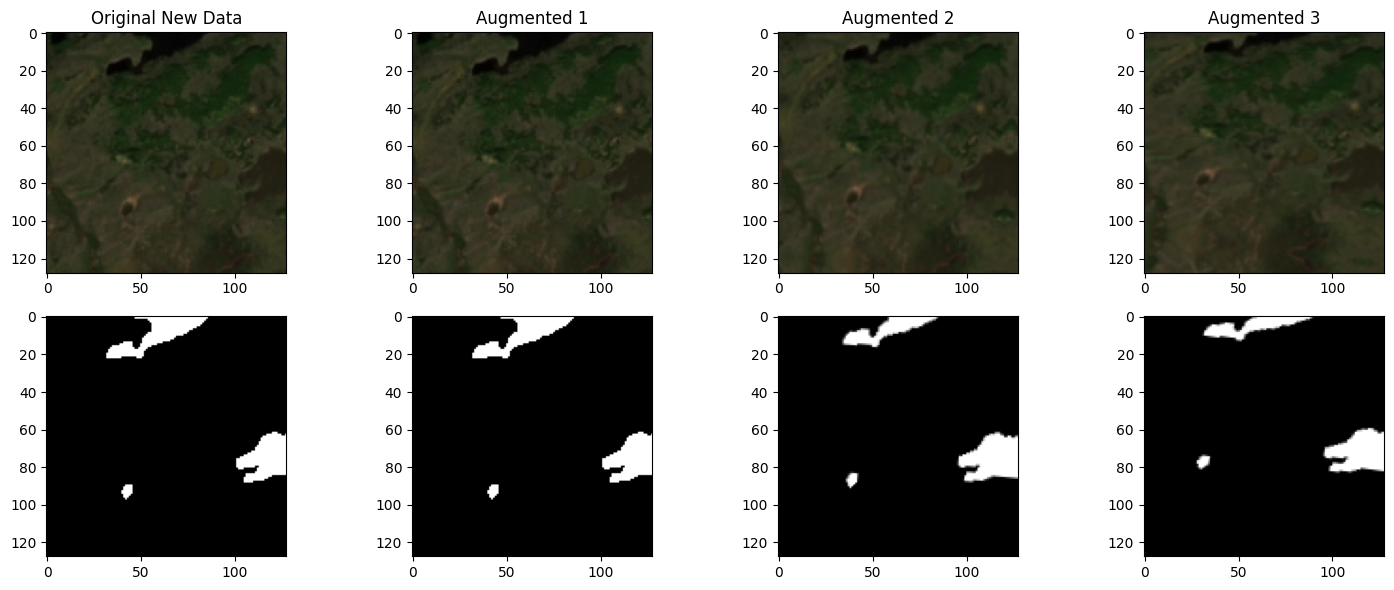

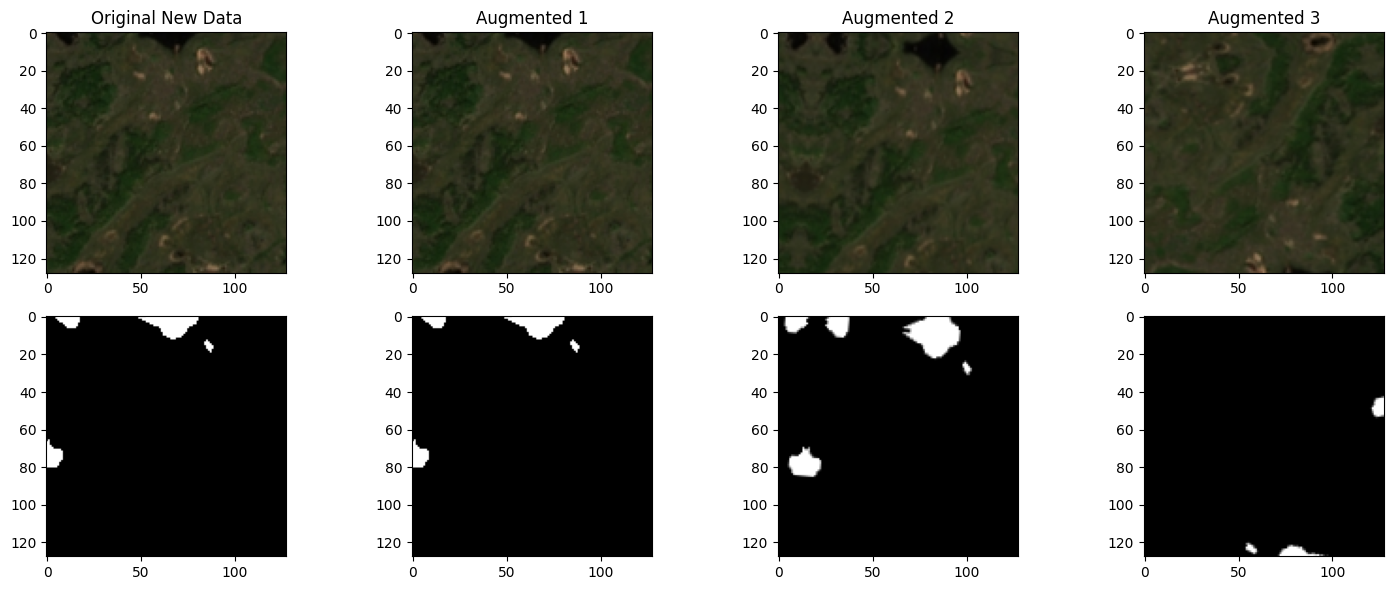

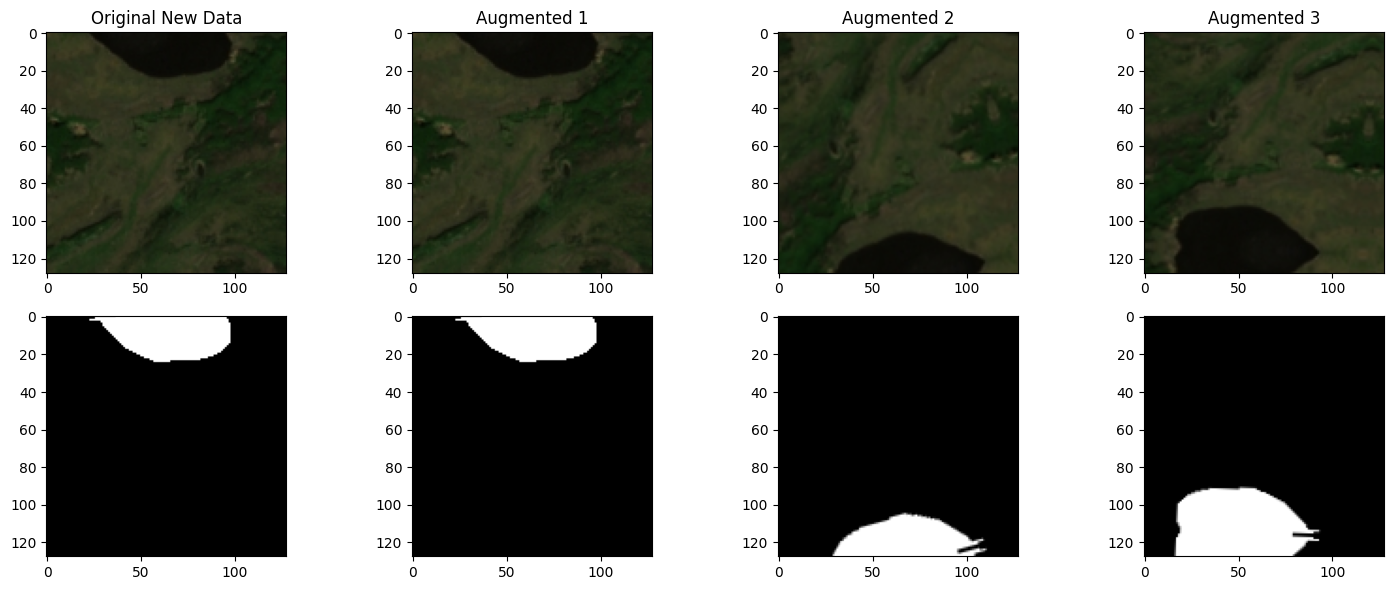

In [5]:
# verify image augmentation is working correctly (on newdata)
if len(new_images) > 0 and len(augmented_new_images) > 0:
    for i in range(min(3, len(new_images))): # Show for up to 3 images
        img = new_images[i]
        mask = new_masks[i]

        fig, ax = plt.subplots(2, augmentation_factor + 1, figsize=(15, 6))
        ax[0][0].imshow(img)
        ax[0][0].set_title("Original New Data")
        ax[1][0].imshow(mask.squeeze(), cmap="gray") # Squeeze to remove single channel dim for imshow
        
        for j in range(augmentation_factor):
            index = i * augmentation_factor + j
            if index < len(augmented_new_images):
                 ax[0][j + 1].imshow(augmented_new_images[index])
                 ax[0][j + 1].set_title(f"Augmented {j+1}")
                 ax[1][j + 1].imshow(augmented_new_masks[index].squeeze(), cmap="gray")
            else:
                 ax[0][j + 1].axis('off') # Turn off empty subplots
                 ax[1][j + 1].axis('off')

        plt.tight_layout()
        plt.show()
else:
    print("Skipping augmentation verification as no new images were loaded or augmented.")

In [6]:
# Define U-net architecture
def unet_model(input_layer, start_neurons):
    # Contraction path
    conv1 = Conv2D(start_neurons, kernel_size=(3, 3), activation="relu", padding="same")(input_layer)
    conv1 = Conv2D(start_neurons, kernel_size=(3, 3), activation="relu", padding="same")(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(0.25)(pool1)

    conv2 = Conv2D(start_neurons*2, kernel_size=(3, 3), activation="relu", padding="same")(pool1)
    conv2 = Conv2D(start_neurons*2, kernel_size=(3, 3), activation="relu", padding="same")(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(0.5)(pool2)

    conv3 = Conv2D(start_neurons*4, kernel_size=(3, 3), activation="relu", padding="same")(pool2)
    conv3 = Conv2D(start_neurons*4, kernel_size=(3, 3), activation="relu", padding="same")(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(0.5)(pool3)

    conv4 = Conv2D(start_neurons*8, kernel_size=(3, 3), activation="relu", padding="same")(pool3)
    conv4 = Conv2D(start_neurons*8, kernel_size=(3, 3), activation="relu", padding="same")(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(0.5)(pool4)

    # Middle
    convm = Conv2D(start_neurons*16, kernel_size=(3, 3), activation="relu", padding="same")(pool4)
    convm = Conv2D(start_neurons*16, kernel_size=(3, 3), activation="relu", padding="same")(convm)
    
    # Expansive path
    deconv4 = Conv2DTranspose(start_neurons*8, kernel_size=(3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(0.5)(uconv4)
    uconv4 = Conv2D(start_neurons*8, kernel_size=(3, 3), activation="relu", padding="same")(uconv4)
    uconv4 = Conv2D(start_neurons*8, kernel_size=(3, 3), activation="relu", padding="same")(uconv4)

    deconv3 = Conv2DTranspose(start_neurons*4, kernel_size=(3, 3), strides=(2, 2), padding="same")(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(0.5)(uconv3)
    uconv3 = Conv2D(start_neurons*4, kernel_size=(3, 3), activation="relu", padding="same")(uconv3)
    uconv3 = Conv2D(start_neurons*4, kernel_size=(3, 3), activation="relu", padding="same")(uconv3)

    deconv2 = Conv2DTranspose(start_neurons*2, kernel_size=(3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(0.5)(uconv2)
    uconv2 = Conv2D(start_neurons*2, kernel_size=(3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = Conv2D(start_neurons*2, kernel_size=(3, 3), activation="relu", padding="same")(uconv2)

    deconv1 = Conv2DTranspose(start_neurons*1, kernel_size=(3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(0.5)(uconv1)
    uconv1 = Conv2D(start_neurons, kernel_size=(3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = Conv2D(start_neurons, kernel_size=(3, 3), activation="relu", padding="same")(uconv1)
    
    # Last conv and output
    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
    
    return output_layer

In [7]:
# Compile unet model
input_layer = Input((SIZE, SIZE, 3))
output_layer = unet_model(input_layer=input_layer, start_neurons=16)

model = Model(input_layer, output_layer)
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
# model.summary()

I0000 00:00:1754375503.599830  589331 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9599 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1


In [8]:
# Post Process
def mask_threshold(image, threshold=0.25):
    return image > threshold


# Callback to show progress of learning on the images after each epoch
class ShowProgress(Callback):
    def __init__(self, save=False):
        self.save = save

    def on_epoch_end(self, epoch, logs=None):
        if len(images_train) == 0:
            print("No training images to show progress on.")
            return
        k = np.random.randint(len(images_train))
        original_image = images_train[k][np.newaxis, ...]
        predicted_mask = self.model.predict(original_image).reshape(SIZE, SIZE)
        proc_mask02 = mask_threshold(predicted_mask, threshold=0.2)
        proc_mask03 = mask_threshold(predicted_mask, threshold=0.3)
        proc_mask04 = mask_threshold(predicted_mask, threshold=0.4)
        proc_mask05 = mask_threshold(predicted_mask, threshold=0.5)
        mask = masks_train[k].reshape(SIZE, SIZE)

        plt.figure(figsize=(15, 10))

        plt.subplot(1, 7, 1)
        plt.imshow(original_image[0])
        plt.title("Orginal Image")

        plt.subplot(1, 7, 2)
        plt.imshow(predicted_mask, cmap="gray")
        plt.title("Predicted Mask")

        plt.subplot(1, 7, 3)
        plt.imshow(mask, cmap="gray")
        plt.title("Orginal Mask")

        plt.subplot(1, 7, 4)
        plt.imshow(proc_mask02, cmap="gray")
        plt.title("Processed: 0.2")

        plt.subplot(1, 7, 5)
        plt.imshow(proc_mask03, cmap="gray")
        plt.title("Processed: 0.3")

        plt.subplot(1, 7, 6)
        plt.imshow(proc_mask04, cmap="gray")
        plt.title("Processed: 0.4")

        plt.subplot(1, 7, 7) # Corrected subplot index from 6 to 7
        plt.imshow(proc_mask05, cmap="gray")
        plt.title("Processed: 0.5")

        plt.tight_layout()
        plt.show()

Epoch 1/75


I0000 00:00:1754375508.771642  589457 service.cc:148] XLA service 0x7f6078004df0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1754375508.771770  589457 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
2025-08-04 23:31:48.852123: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1754375509.180540  589457 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-08-04 23:31:49.778613: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[64,16,128,128]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,3,128,128]{3,2,1,0}, f32[16,3,3,3]{3,2,1,0}, f32[16]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_con

112/113 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.6140 - loss: 0.4610

2025-08-04 23:32:11.881385: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[43,16,128,128]{3,2,1,0}, u8[0]{0}) custom-call(f32[43,3,128,128]{3,2,1,0}, f32[16,3,3,3]{3,2,1,0}, f32[16]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-08-04 23:32:11.966337: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[43,16,128,128]{3,2,1,0}, u8[0]{0}) custom-call(f32[43,16,128,128]{3,2,1,0}, f32[16,16,3,3]{3,2,1,0}, f32[16]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationFor

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.6142 - loss: 0.4599

2025-08-04 23:32:20.671547: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'input_transpose_fusion_4', 8 bytes spill stores, 8 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_transpose_fusion', 8 bytes spill stores, 8 bytes spill loads

2025-08-04 23:32:20.945738: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[1,16,128,128]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,3,128,128]{3,2,1,0}, f32[16,3,3,3]{3,2,1,0}, f32[16]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-08-04 23:32:

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 715ms/step


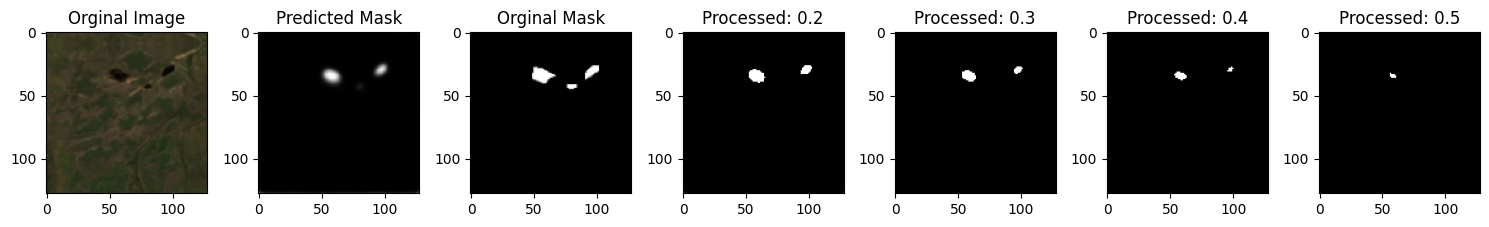

113/113 ━━━━━━━━━━━━━━━━━━━━ 35s 172ms/step - accuracy: 0.6143 - loss: 0.4588
Epoch 2/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.6455 - loss: 0.23


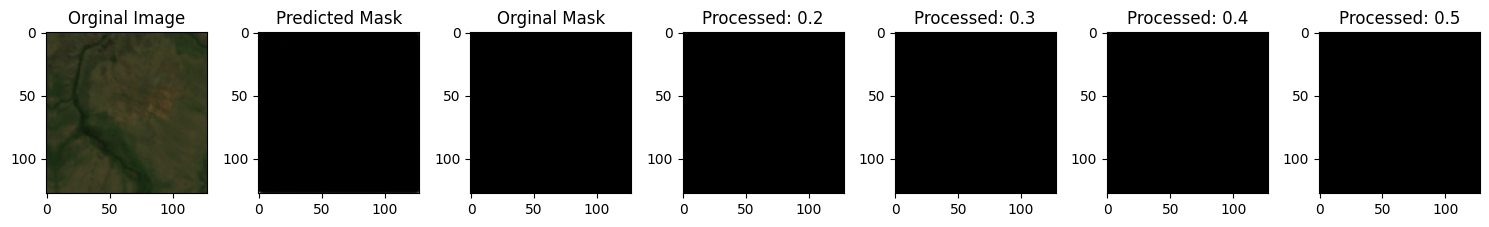

113/113 ━━━━━━━━━━━━━━━━━━━━ 10s 84ms/step - accuracy: 0.6455 - loss: 0.2309
Epoch 3/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.6372 - loss: 0.22


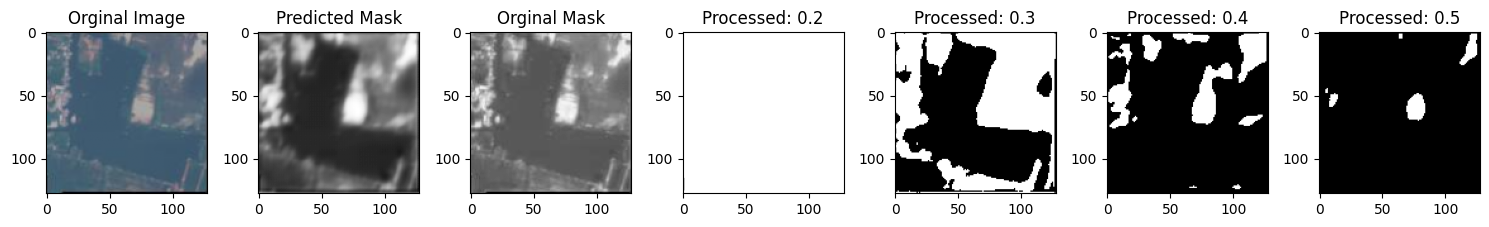

113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - accuracy: 0.6373 - loss: 0.2271
Epoch 4/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/stepstep - accuracy: 0.6508 - loss: 0.219


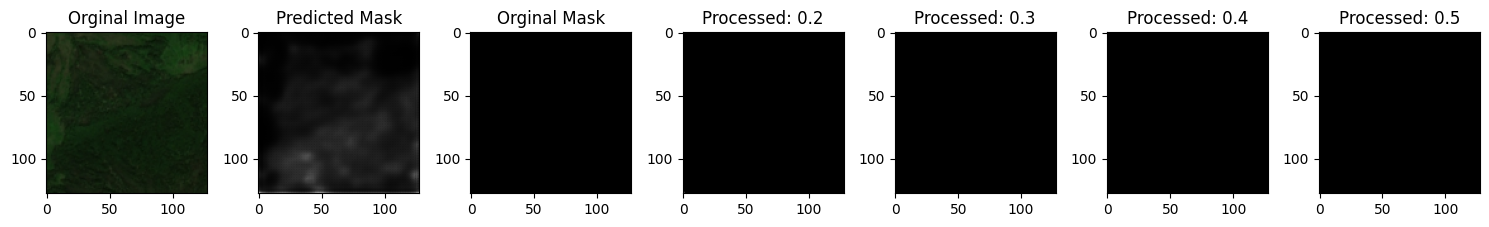

113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - accuracy: 0.6507 - loss: 0.2190
Epoch 5/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.6465 - loss: 0.215


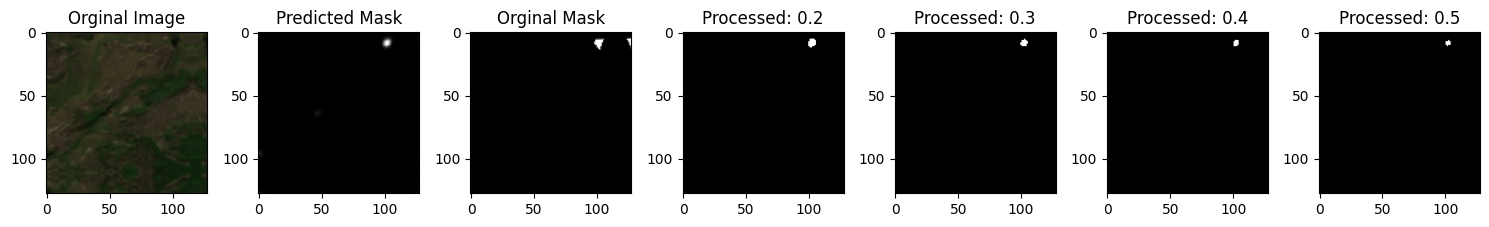

113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - accuracy: 0.6465 - loss: 0.2159
Epoch 6/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.6412 - loss: 0.21


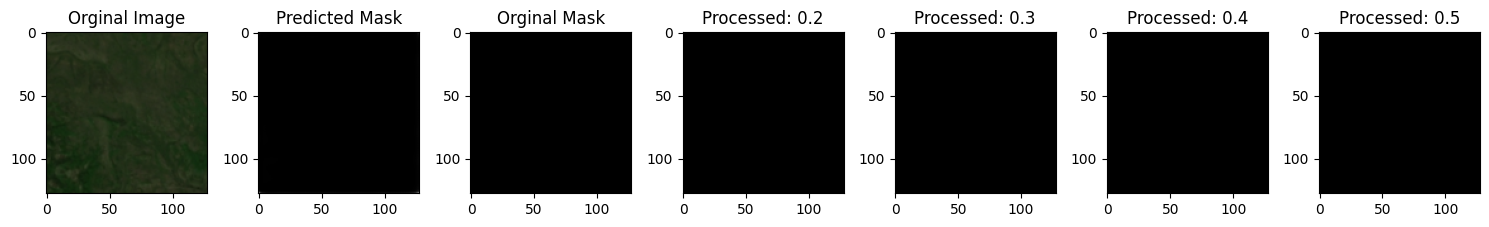

113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 82ms/step - accuracy: 0.6412 - loss: 0.2195
Epoch 7/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.6458 - loss: 0.21


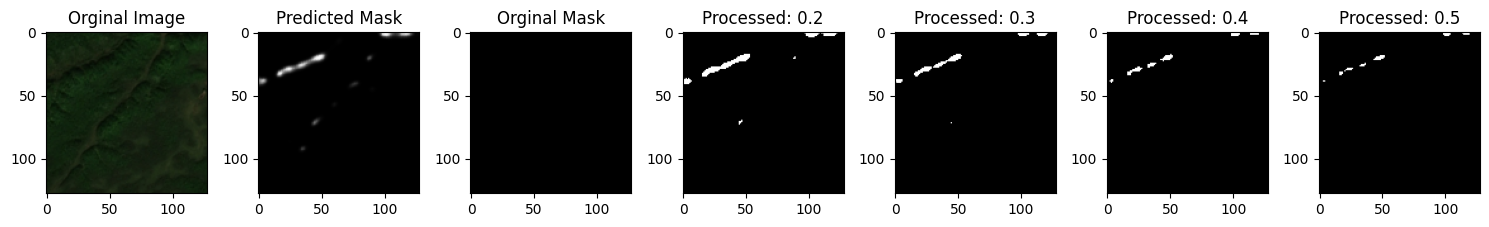

113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 82ms/step - accuracy: 0.6458 - loss: 0.2129
Epoch 8/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step/step - accuracy: 0.6492 - loss: 0.21


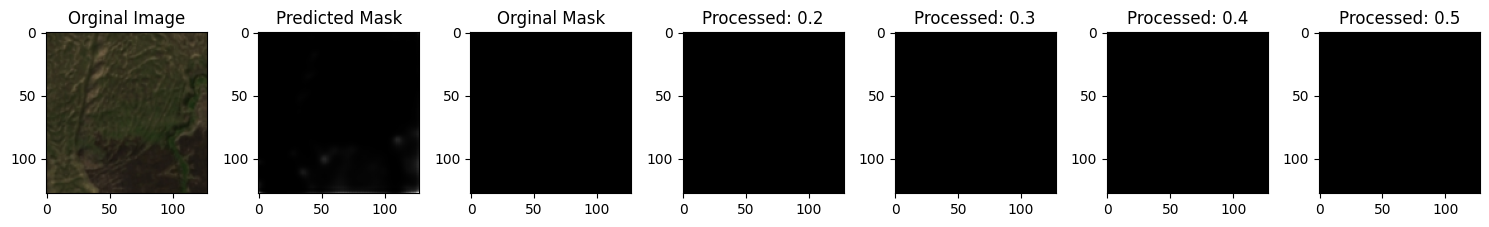

113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - accuracy: 0.6492 - loss: 0.2130
Epoch 9/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step/step - accuracy: 0.6401 - loss: 0.21


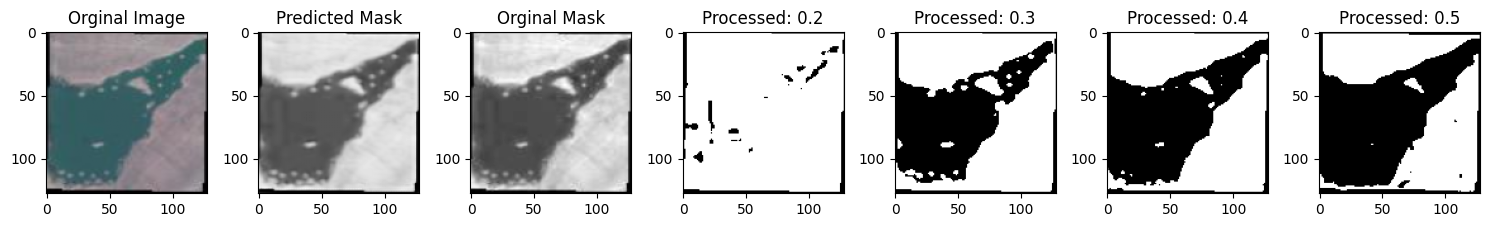

113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - accuracy: 0.6401 - loss: 0.2152
Epoch 10/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.6443 - loss: 0.21


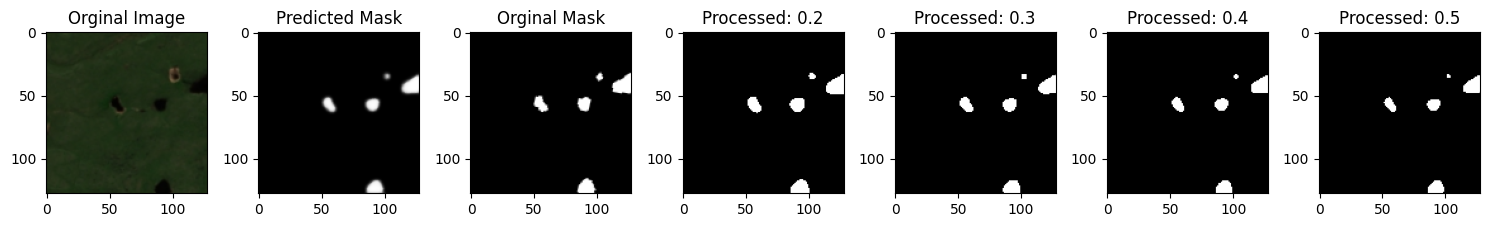

113/113 ━━━━━━━━━━━━━━━━━━━━ 10s 84ms/step - accuracy: 0.6443 - loss: 0.2139
Epoch 11/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.6513 - loss: 0.20


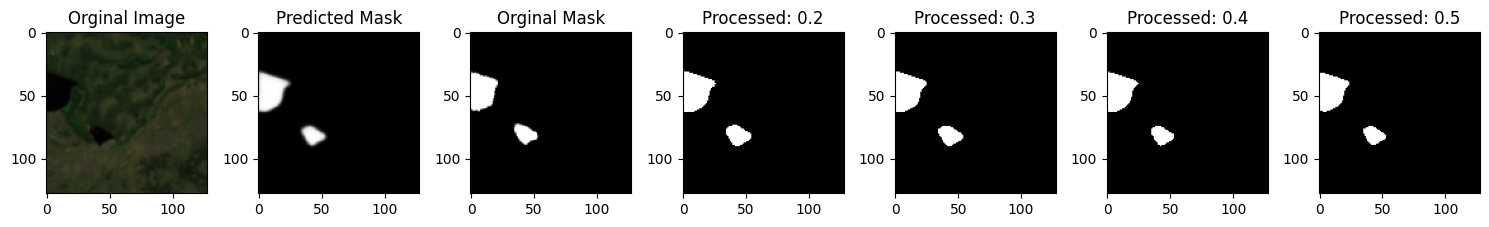

113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - accuracy: 0.6513 - loss: 0.2090
Epoch 12/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.6543 - loss: 0.20


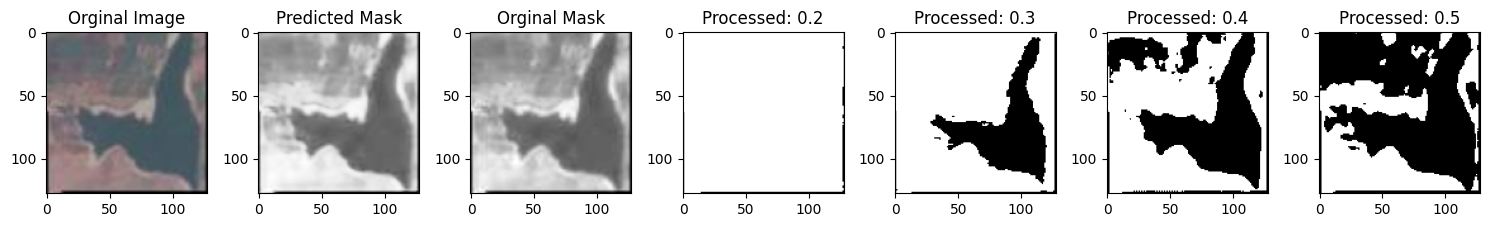

113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - accuracy: 0.6542 - loss: 0.2055
Epoch 13/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.6451 - loss: 0.21


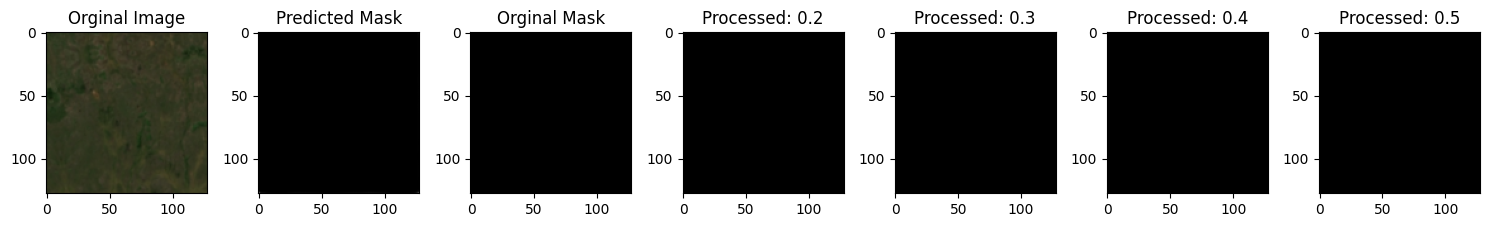

113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - accuracy: 0.6451 - loss: 0.2120
Epoch 14/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step/step - accuracy: 0.6474 - loss: 0.20


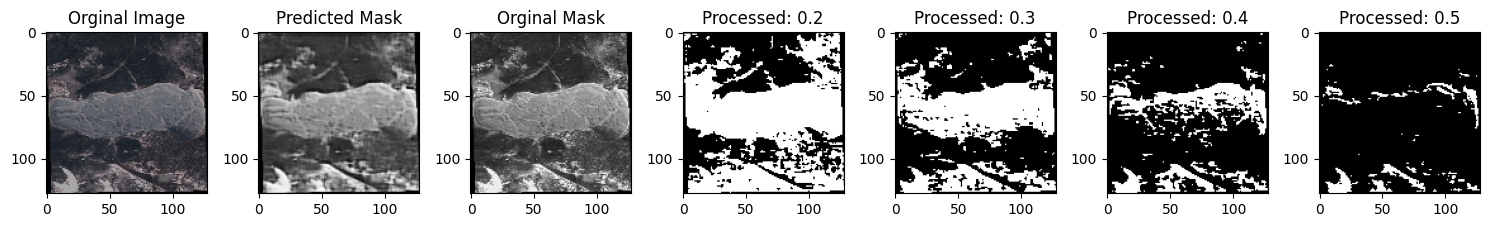

113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - accuracy: 0.6474 - loss: 0.2086
Epoch 15/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.6522 - loss: 0.20


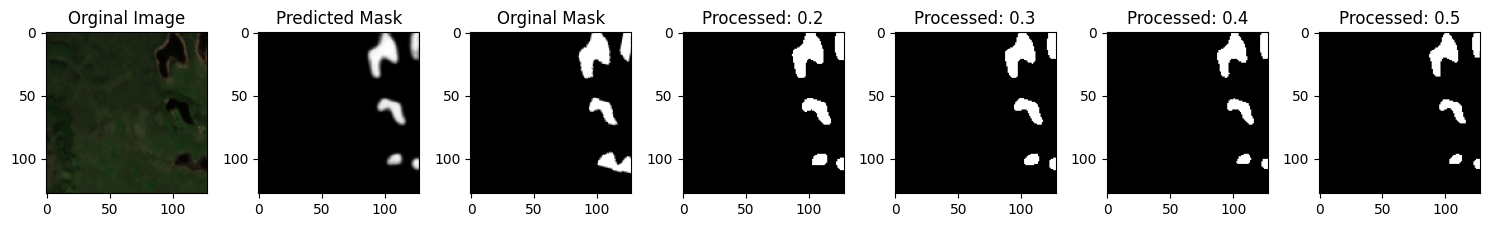

113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - accuracy: 0.6522 - loss: 0.2060
Epoch 16/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.6482 - loss: 0.21


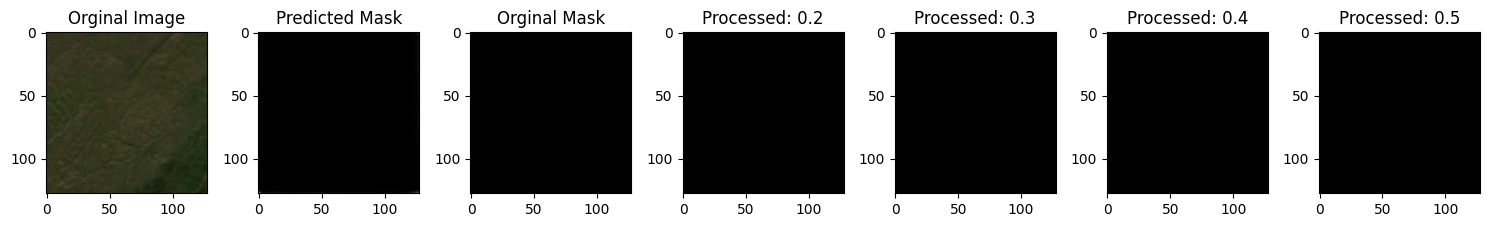

113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - accuracy: 0.6482 - loss: 0.2124
Epoch 17/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.6387 - loss: 0.21


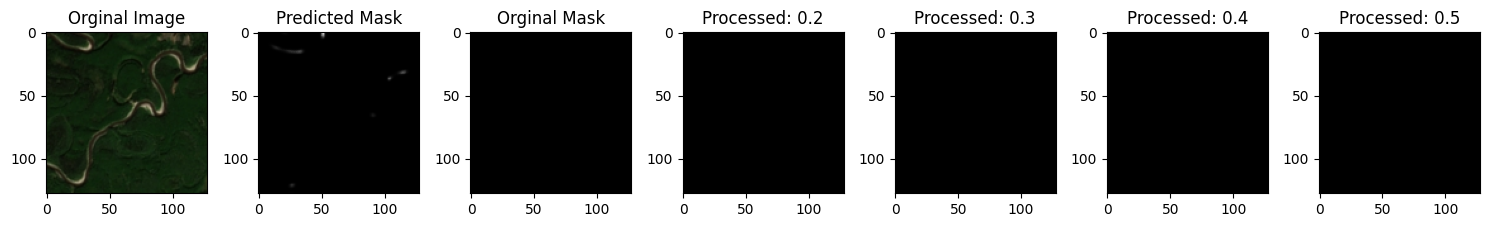

113/113 ━━━━━━━━━━━━━━━━━━━━ 10s 84ms/step - accuracy: 0.6387 - loss: 0.2186
Epoch 18/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.6415 - loss: 0.215


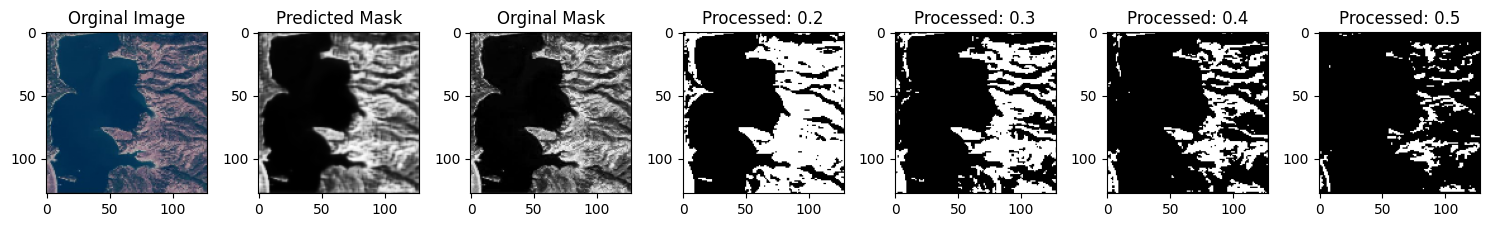

113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - accuracy: 0.6415 - loss: 0.2153
Epoch 19/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.6497 - loss: 0.207


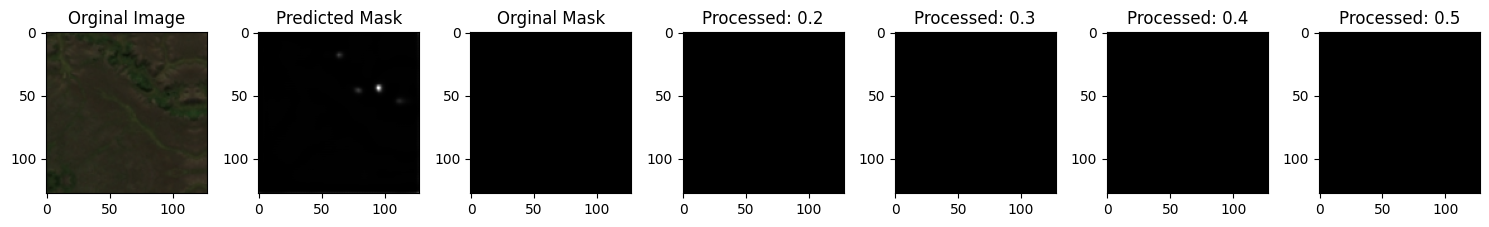

113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - accuracy: 0.6497 - loss: 0.2079
Epoch 20/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.6399 - loss: 0.21


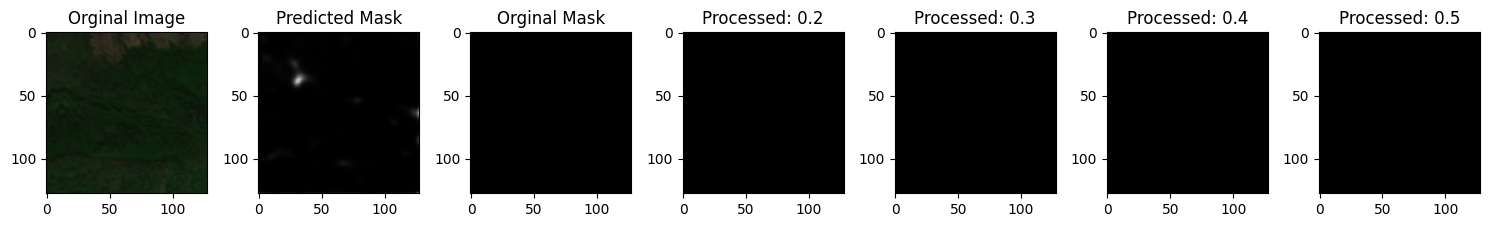

113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 82ms/step - accuracy: 0.6400 - loss: 0.2109
Epoch 21/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.6530 - loss: 0.20


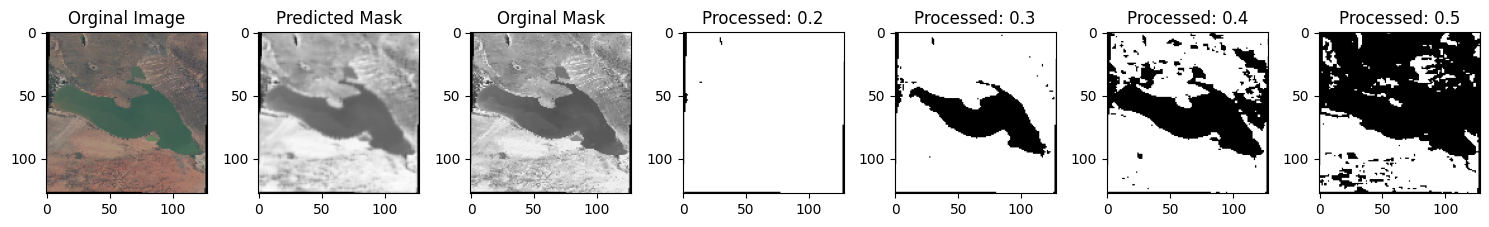

113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 82ms/step - accuracy: 0.6529 - loss: 0.2048
Epoch 22/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.6467 - loss: 0.20


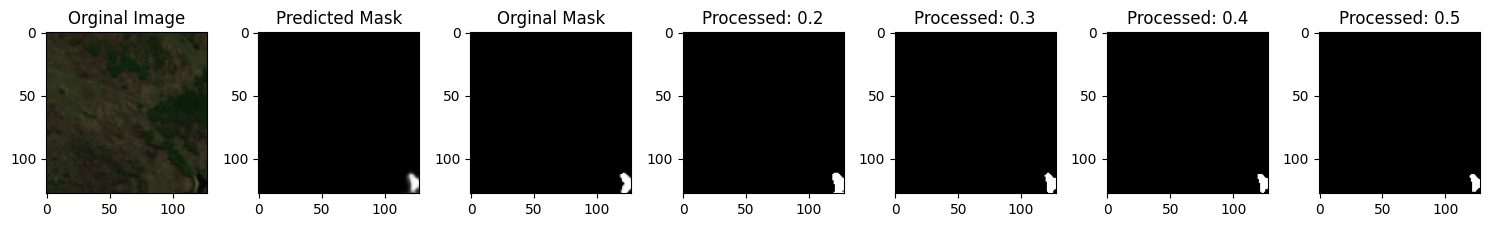

113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 82ms/step - accuracy: 0.6467 - loss: 0.2088
Epoch 23/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.6517 - loss: 0.205


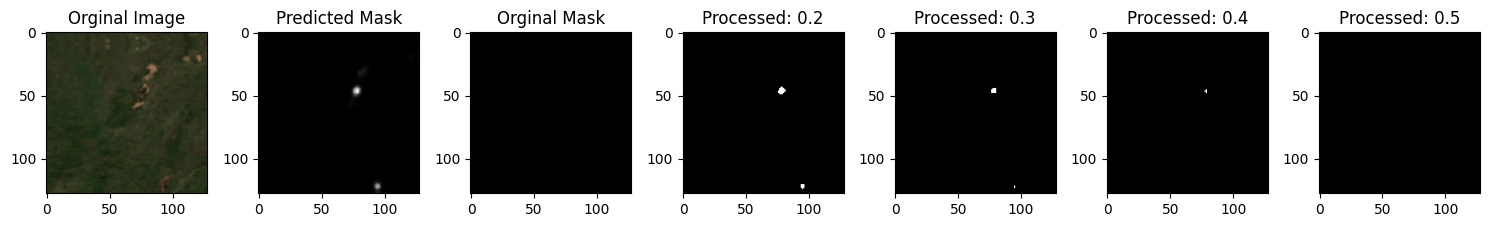

113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - accuracy: 0.6516 - loss: 0.2051
Epoch 24/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.6455 - loss: 0.20


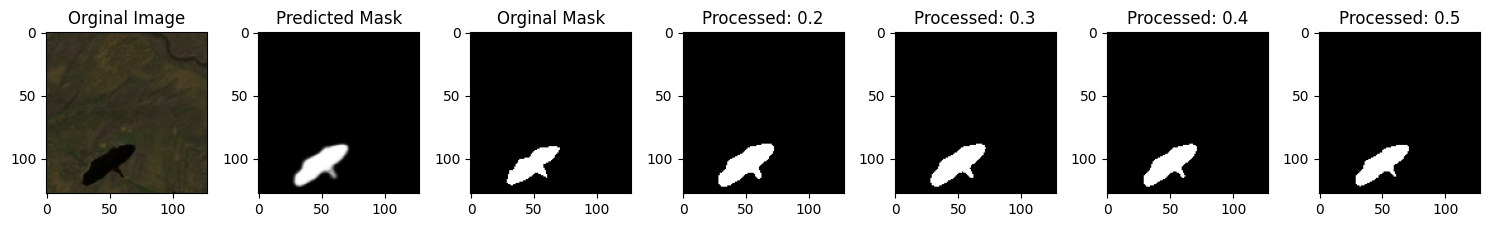

113/113 ━━━━━━━━━━━━━━━━━━━━ 10s 84ms/step - accuracy: 0.6455 - loss: 0.2094
Epoch 25/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.6473 - loss: 0.208


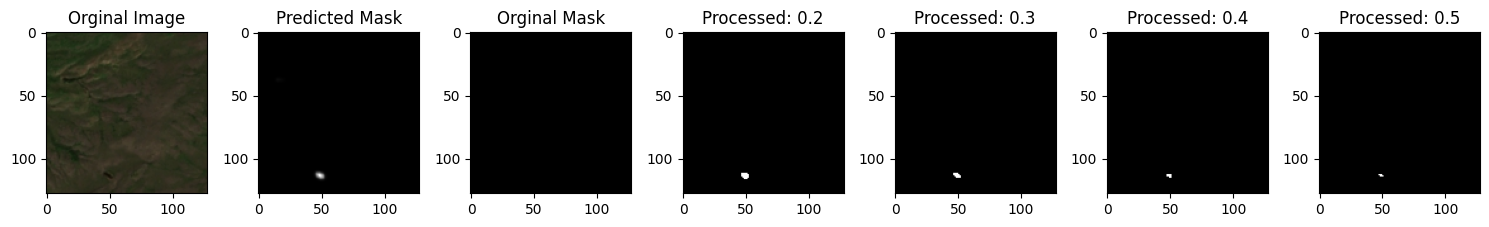

113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - accuracy: 0.6473 - loss: 0.2084
Epoch 26/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.6471 - loss: 0.215


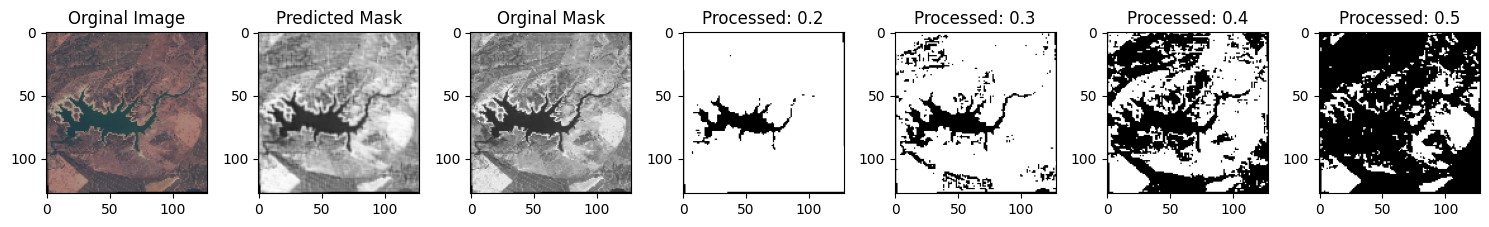

113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - accuracy: 0.6471 - loss: 0.2154
Epoch 27/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.6515 - loss: 0.208


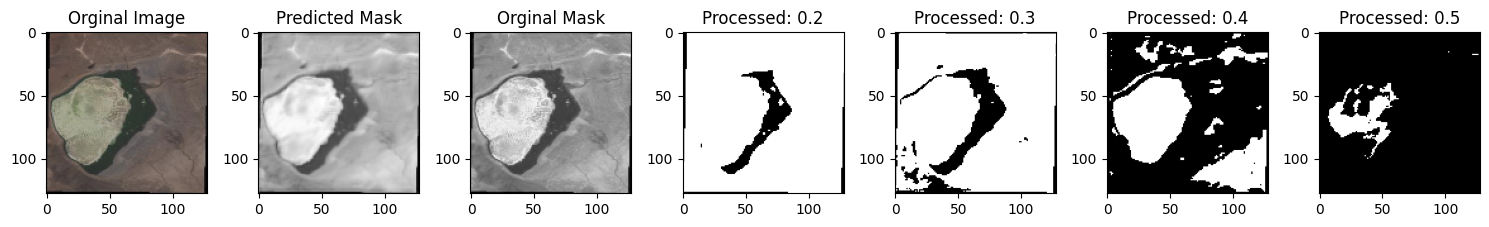

113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - accuracy: 0.6514 - loss: 0.2089
Epoch 28/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/stepstep - accuracy: 0.6457 - loss: 0.212


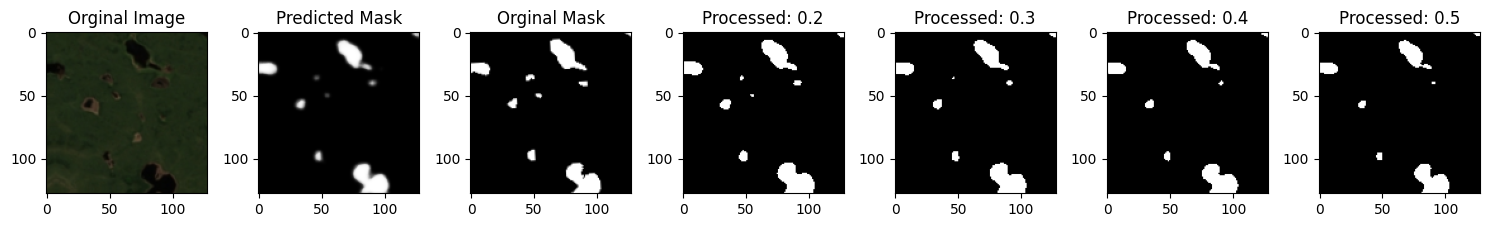

113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - accuracy: 0.6457 - loss: 0.2121
Epoch 29/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.6464 - loss: 0.20


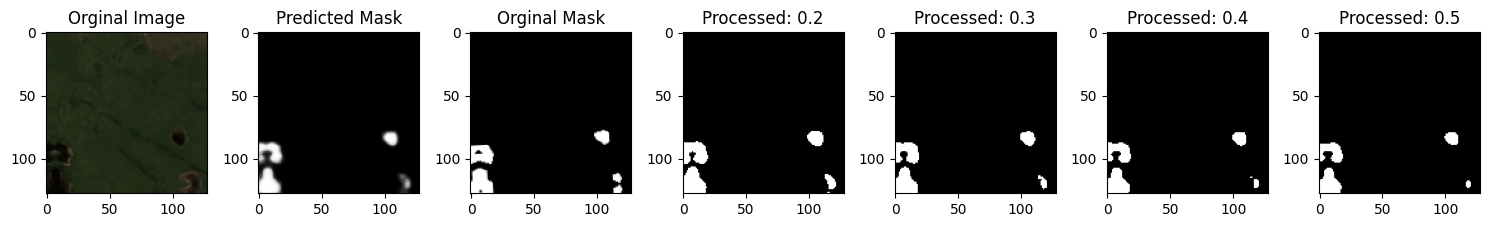

113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - accuracy: 0.6464 - loss: 0.2076
Epoch 30/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.6395 - loss: 0.21


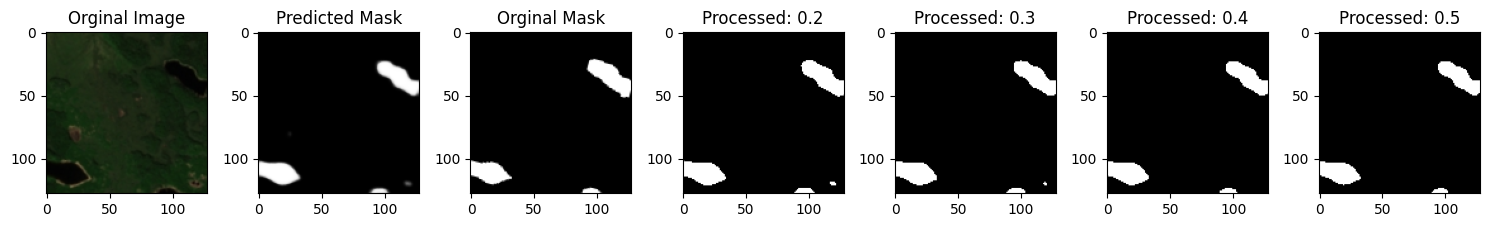

113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 82ms/step - accuracy: 0.6395 - loss: 0.2129
Epoch 31/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.6400 - loss: 0.21


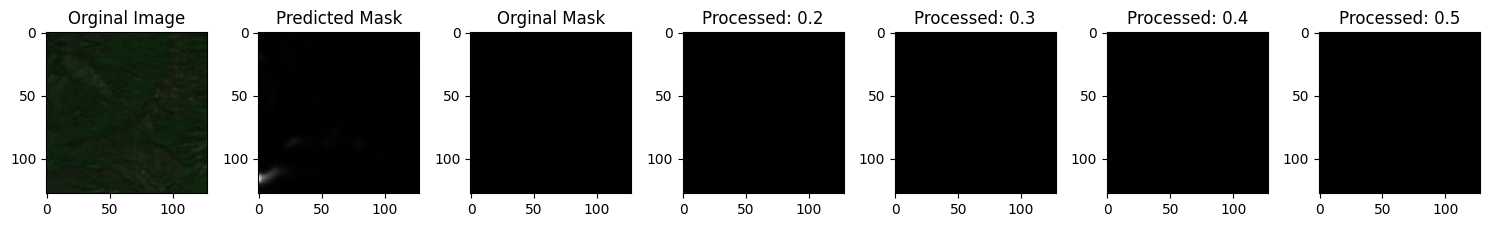

113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 84ms/step - accuracy: 0.6401 - loss: 0.2124
Epoch 32/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.6470 - loss: 0.20


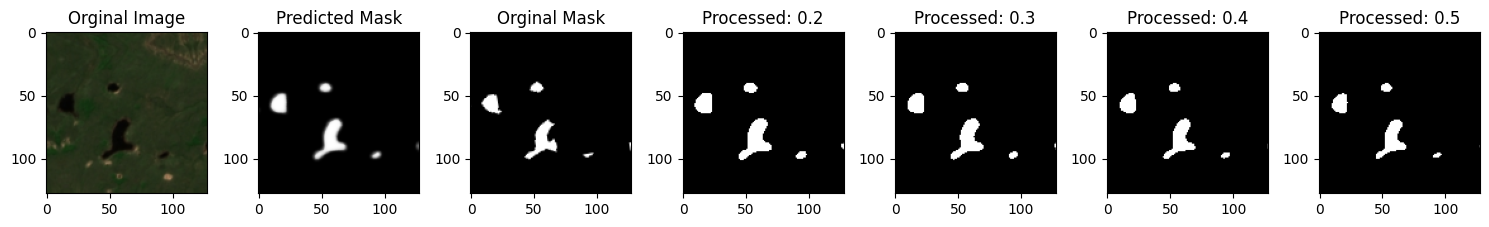

113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - accuracy: 0.6470 - loss: 0.2073
Epoch 33/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.6453 - loss: 0.20


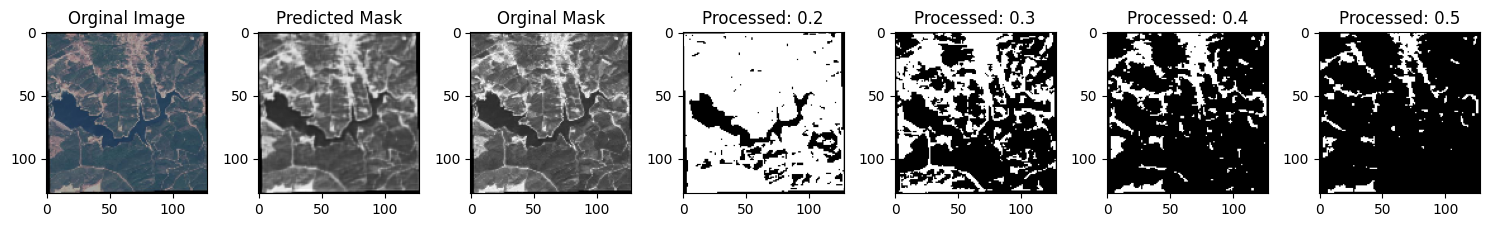

113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 82ms/step - accuracy: 0.6453 - loss: 0.2090
Epoch 34/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.6485 - loss: 0.20


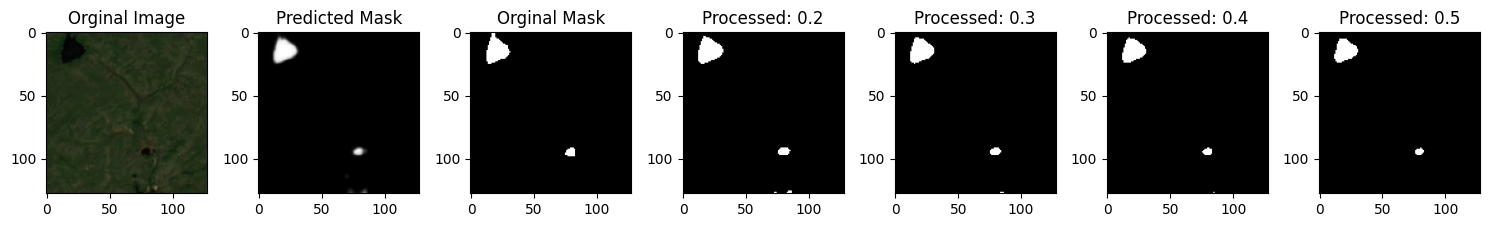

113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 82ms/step - accuracy: 0.6485 - loss: 0.2054
Epoch 35/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step/step - accuracy: 0.6482 - loss: 0.21


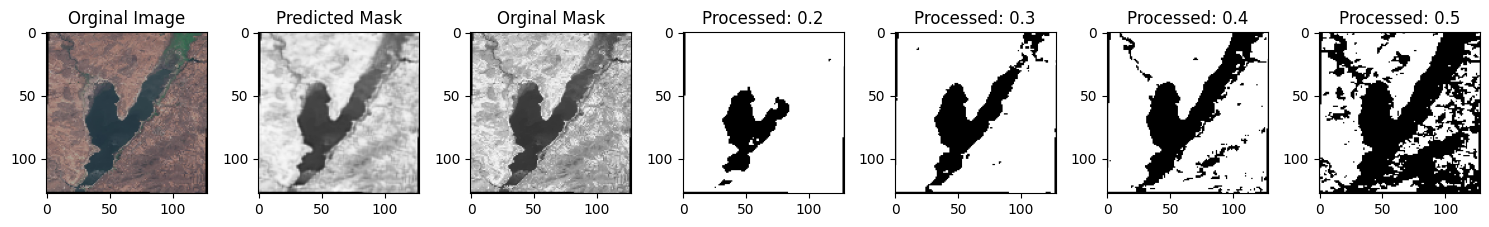

113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - accuracy: 0.6482 - loss: 0.2156
Epoch 36/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.6477 - loss: 0.21


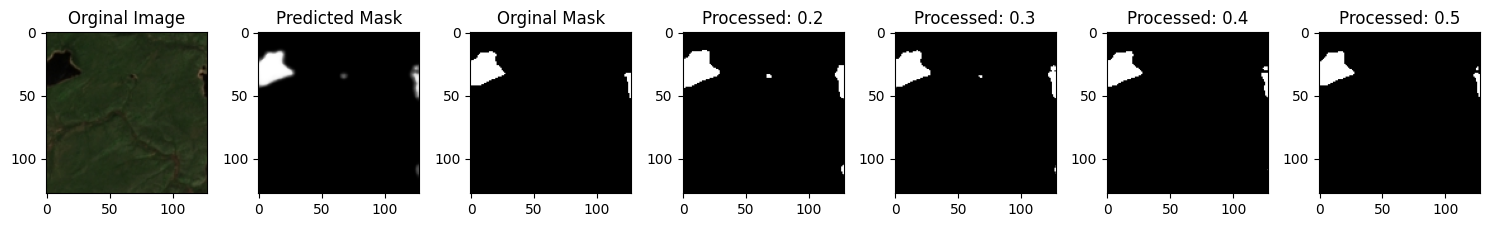

113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - accuracy: 0.6477 - loss: 0.2117
Epoch 37/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/stepstep - accuracy: 0.6468 - loss: 0.209


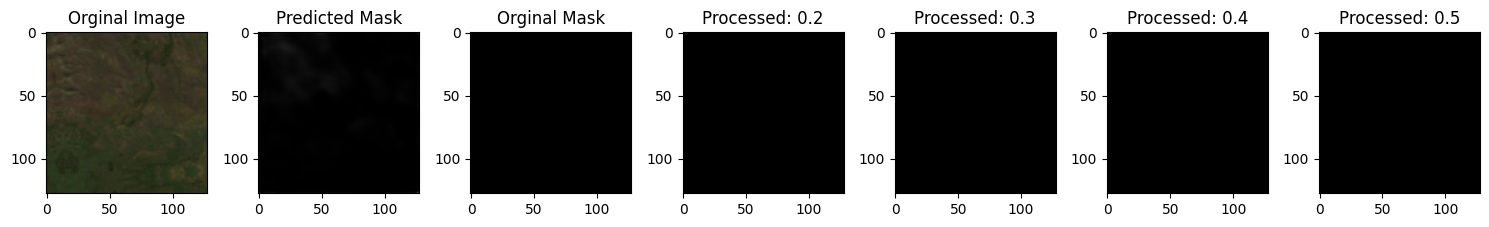

113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - accuracy: 0.6467 - loss: 0.2092
Epoch 38/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.6545 - loss: 0.20


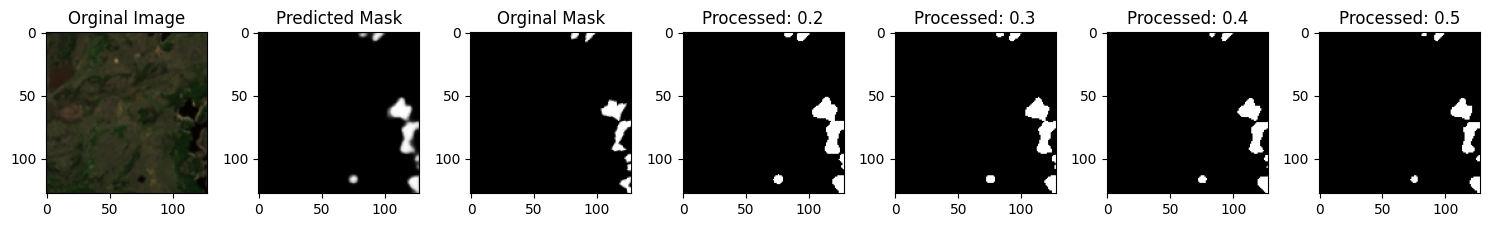

113/113 ━━━━━━━━━━━━━━━━━━━━ 10s 84ms/step - accuracy: 0.6544 - loss: 0.2043
Epoch 39/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.6517 - loss: 0.20


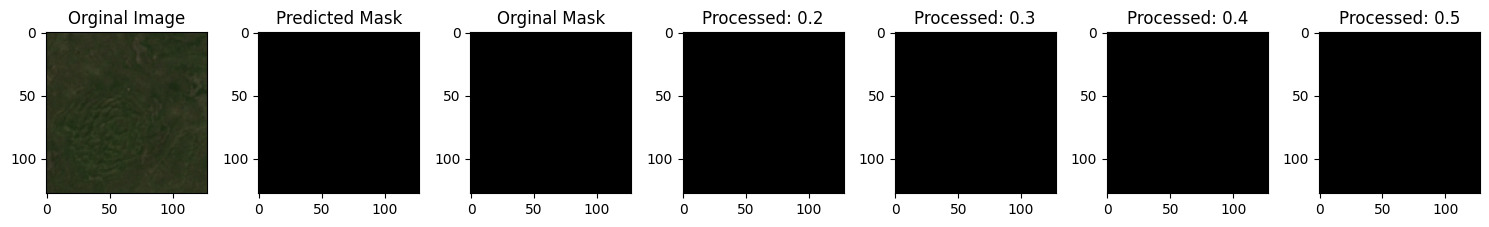

113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - accuracy: 0.6517 - loss: 0.2043
Epoch 40/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.6363 - loss: 0.21


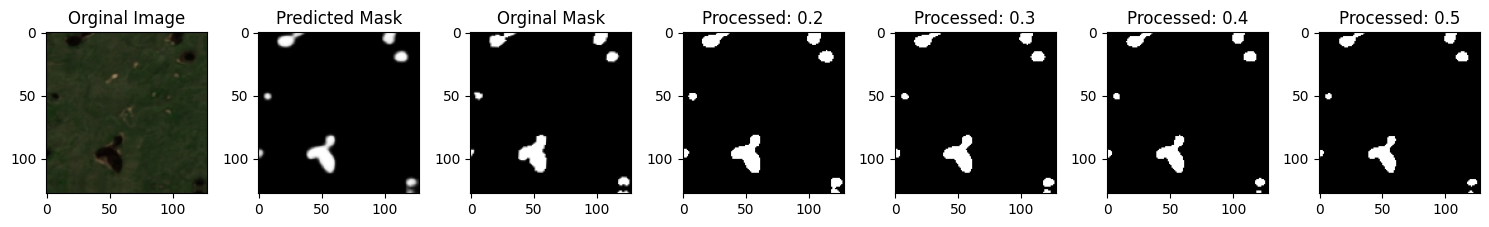

113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - accuracy: 0.6364 - loss: 0.2175
Epoch 41/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.6473 - loss: 0.20


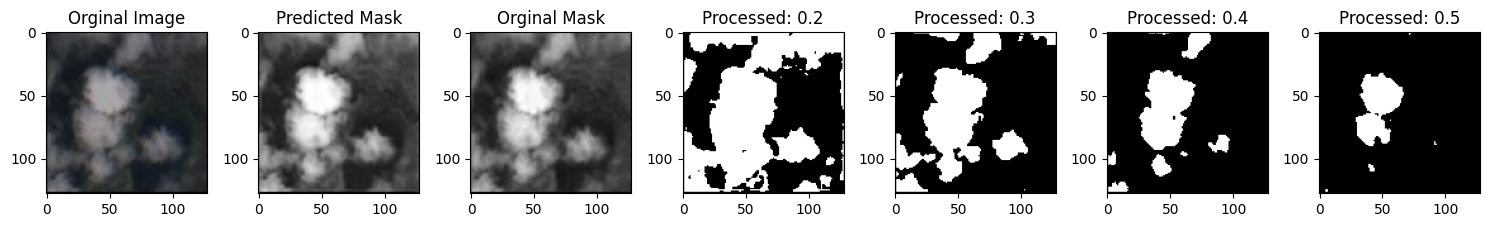

113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - accuracy: 0.6473 - loss: 0.2099
Epoch 42/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.6486 - loss: 0.207


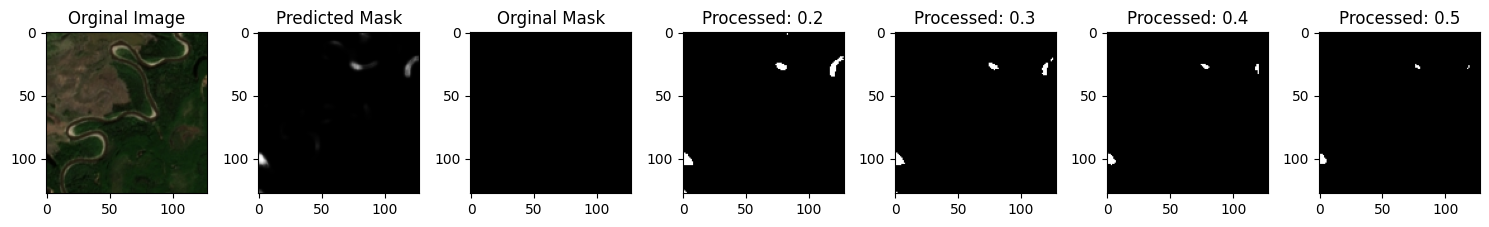

113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 82ms/step - accuracy: 0.6486 - loss: 0.2077
Epoch 43/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.6503 - loss: 0.20


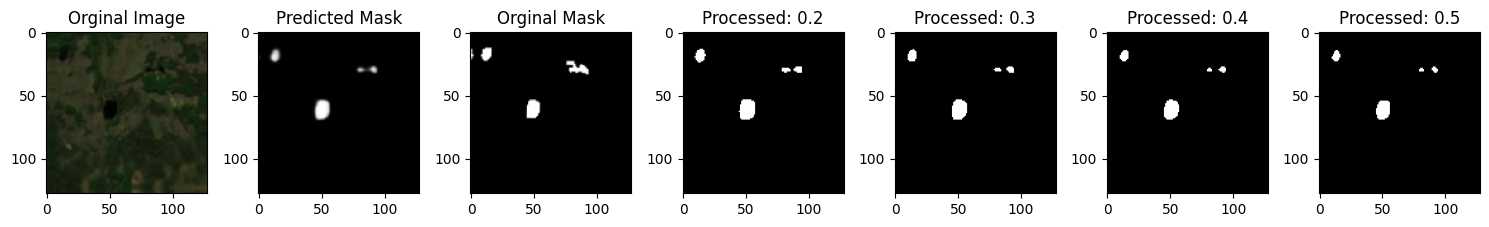

113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 82ms/step - accuracy: 0.6502 - loss: 0.2046
Epoch 44/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.6402 - loss: 0.21


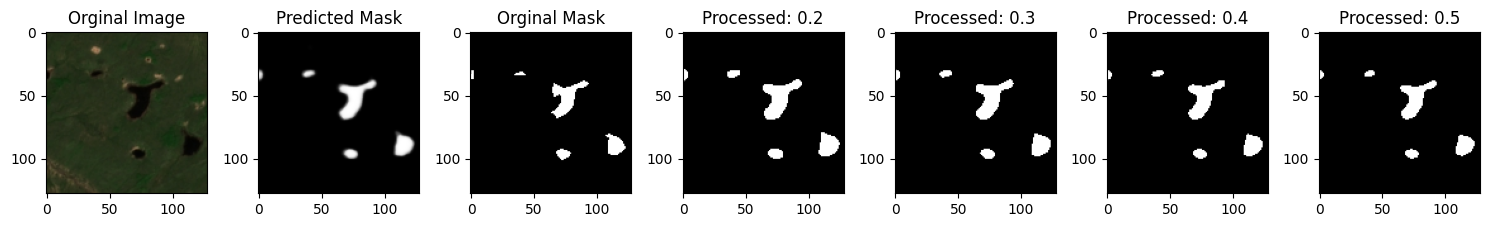

113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 82ms/step - accuracy: 0.6403 - loss: 0.2105
Epoch 45/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/stepstep - accuracy: 0.6431 - loss: 0.209


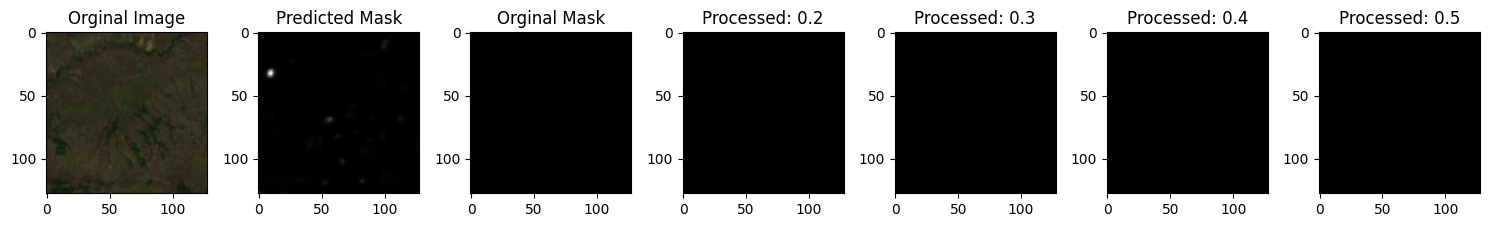

113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 82ms/step - accuracy: 0.6431 - loss: 0.2093
Epoch 46/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step/step - accuracy: 0.6511 - loss: 0.20


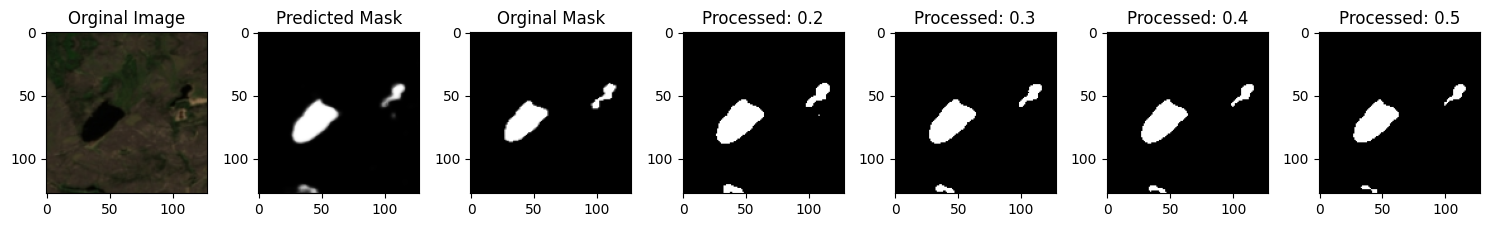

113/113 ━━━━━━━━━━━━━━━━━━━━ 10s 84ms/step - accuracy: 0.6510 - loss: 0.2042
Epoch 47/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.6570 - loss: 0.20


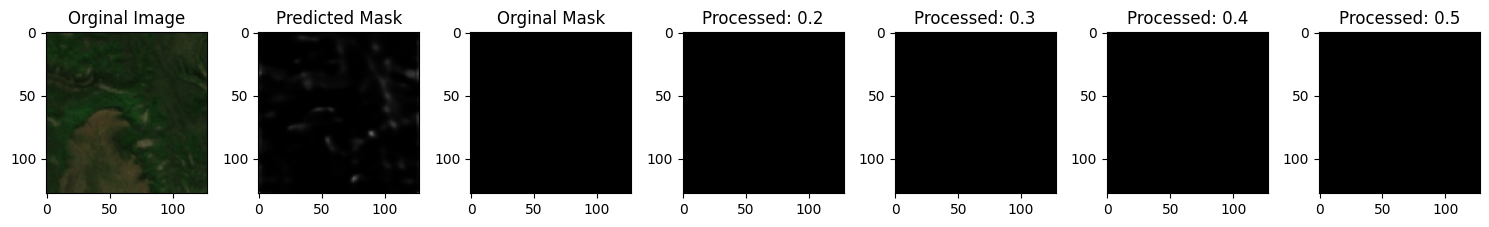

113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - accuracy: 0.6569 - loss: 0.2007
Epoch 48/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.6592 - loss: 0.20


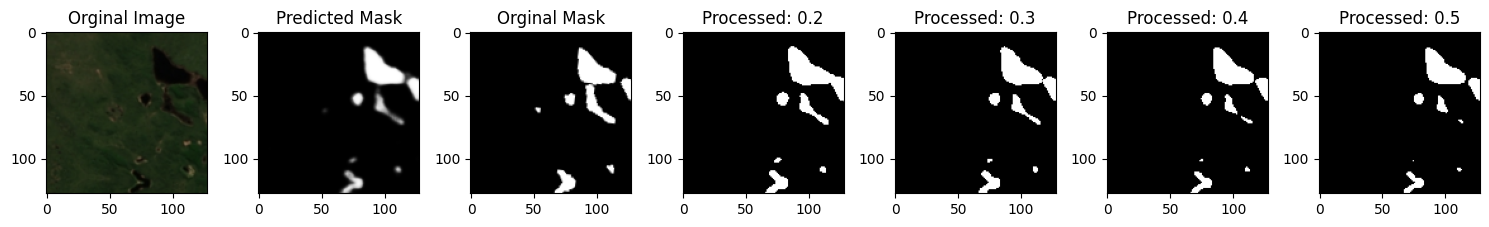

113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - accuracy: 0.6591 - loss: 0.2004
Epoch 49/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.6352 - loss: 0.21


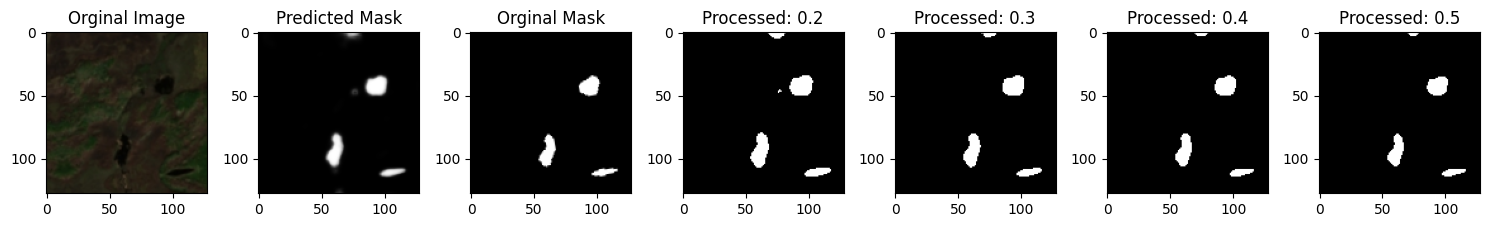

113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - accuracy: 0.6354 - loss: 0.2134
Epoch 50/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.6501 - loss: 0.20


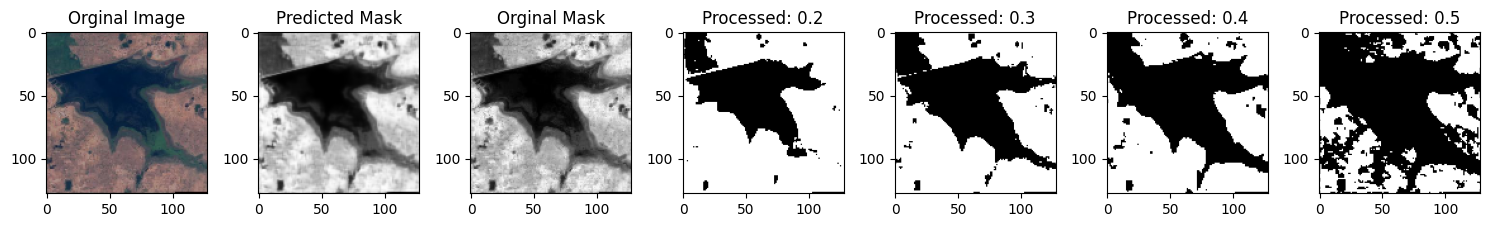

113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - accuracy: 0.6500 - loss: 0.2058
Epoch 51/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.6323 - loss: 0.21


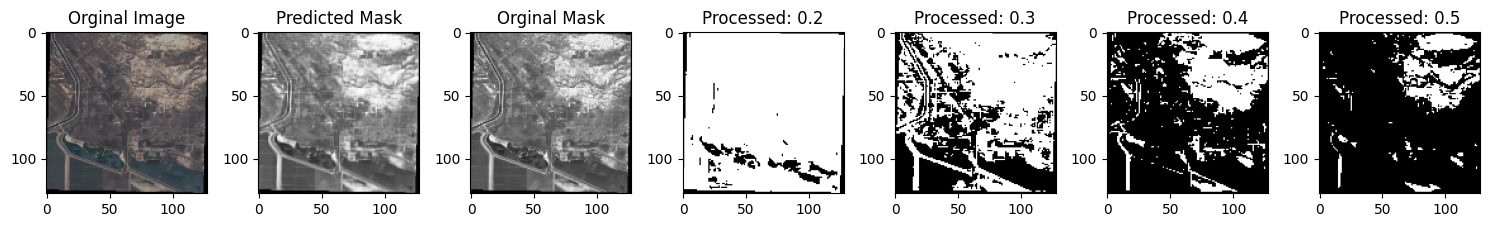

113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - accuracy: 0.6324 - loss: 0.2149
Epoch 52/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.6484 - loss: 0.20


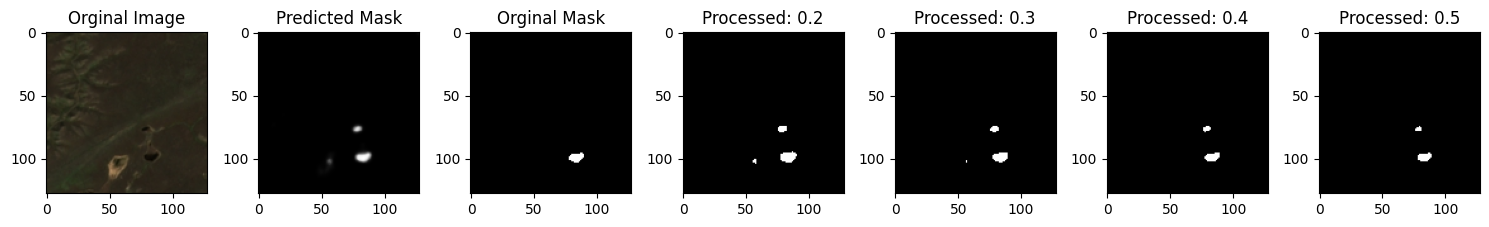

113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - accuracy: 0.6483 - loss: 0.2098
Epoch 53/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.6397 - loss: 0.211


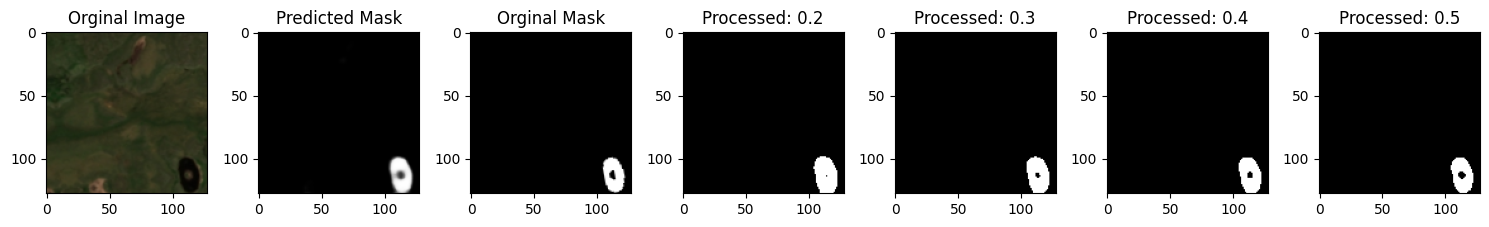

113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 84ms/step - accuracy: 0.6397 - loss: 0.2118
Epoch 54/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/stepstep - accuracy: 0.6560 - loss: 0.201


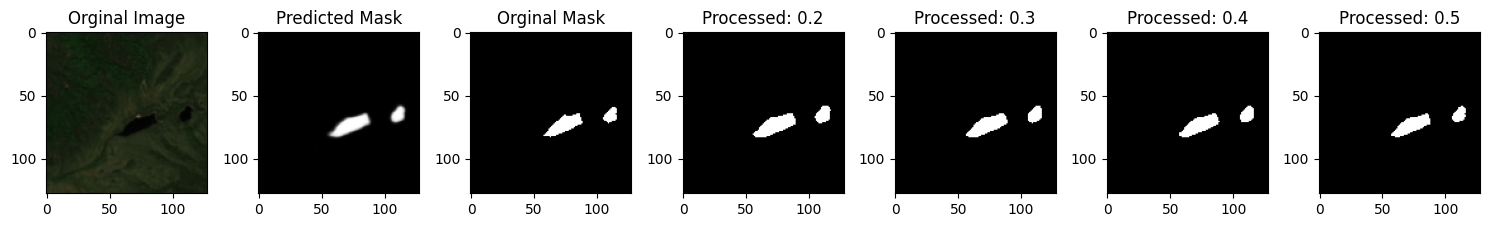

113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - accuracy: 0.6559 - loss: 0.2018
Epoch 55/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.6456 - loss: 0.207


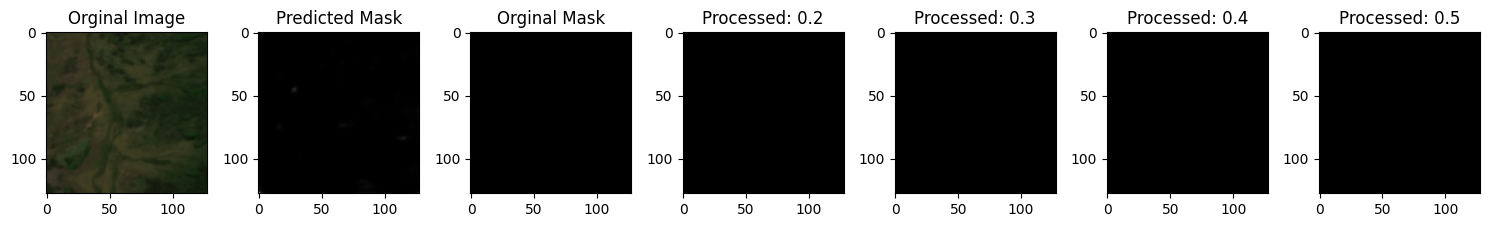

113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 82ms/step - accuracy: 0.6456 - loss: 0.2075
Epoch 56/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.6592 - loss: 0.19


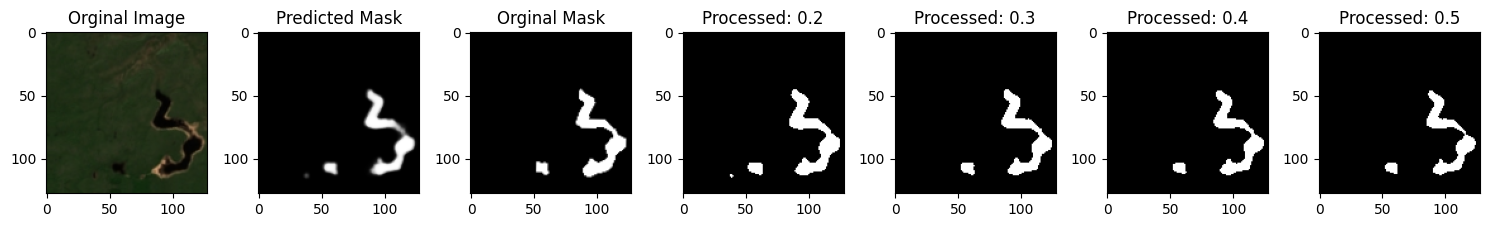

113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 82ms/step - accuracy: 0.6591 - loss: 0.1993
Epoch 57/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/stepstep - accuracy: 0.6445 - loss: 0.208


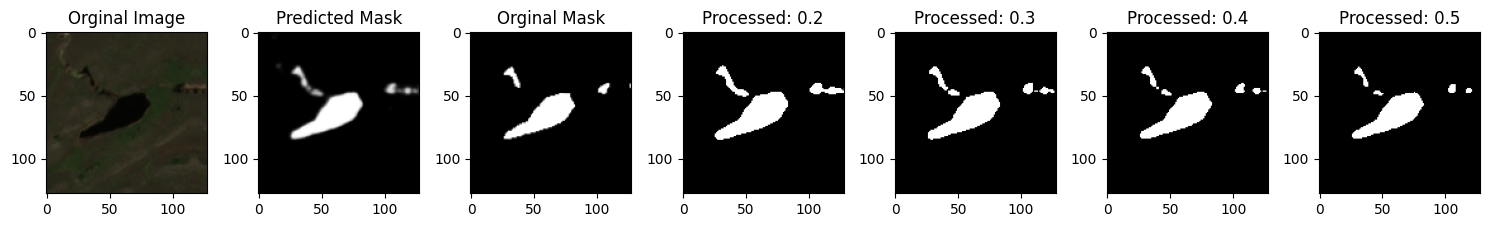

113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 82ms/step - accuracy: 0.6445 - loss: 0.2085
Epoch 58/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.6428 - loss: 0.209


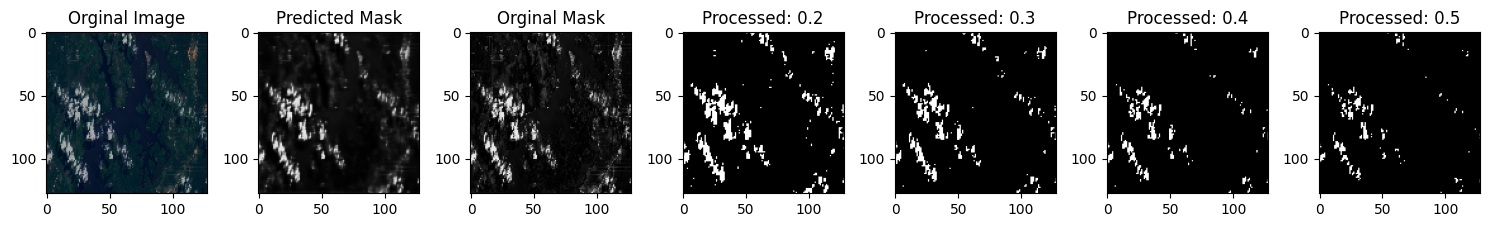

113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - accuracy: 0.6428 - loss: 0.2097
Epoch 59/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.6499 - loss: 0.20


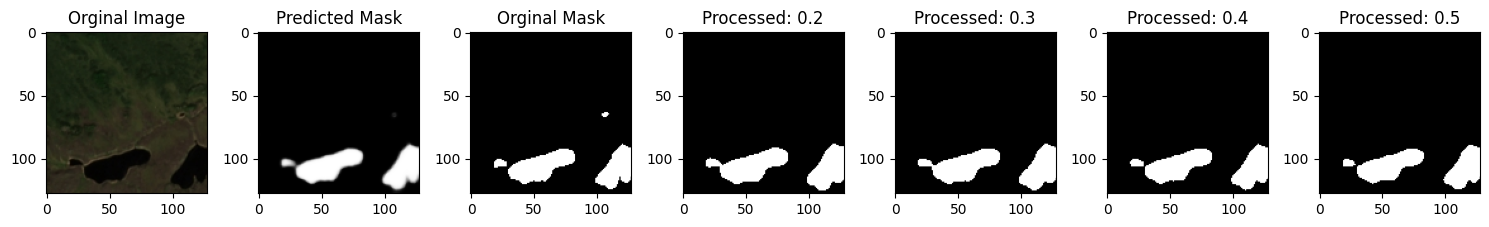

113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - accuracy: 0.6499 - loss: 0.2050
Epoch 60/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.6378 - loss: 0.21


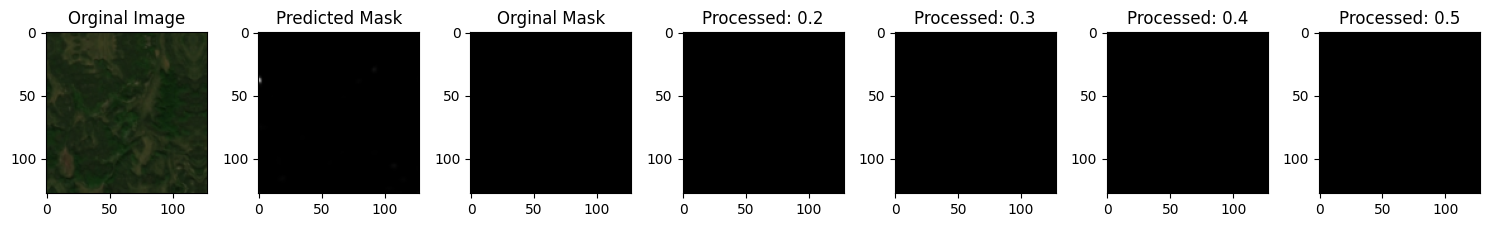

113/113 ━━━━━━━━━━━━━━━━━━━━ 10s 84ms/step - accuracy: 0.6379 - loss: 0.2124
Epoch 61/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.6525 - loss: 0.205


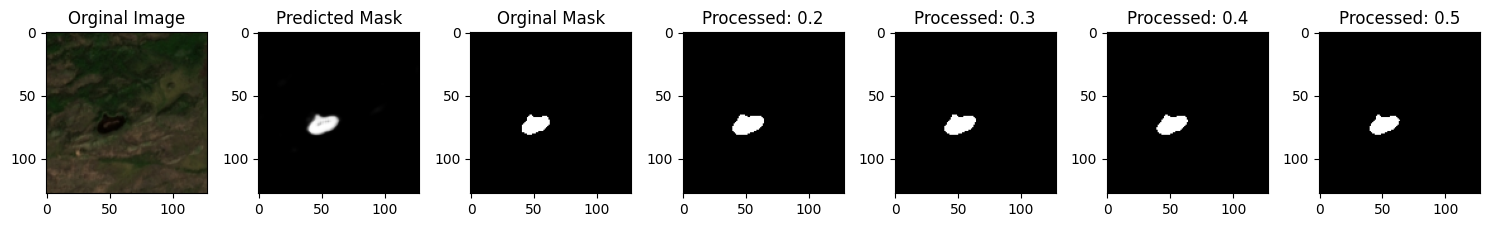

113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - accuracy: 0.6524 - loss: 0.2051
Epoch 62/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.6457 - loss: 0.20


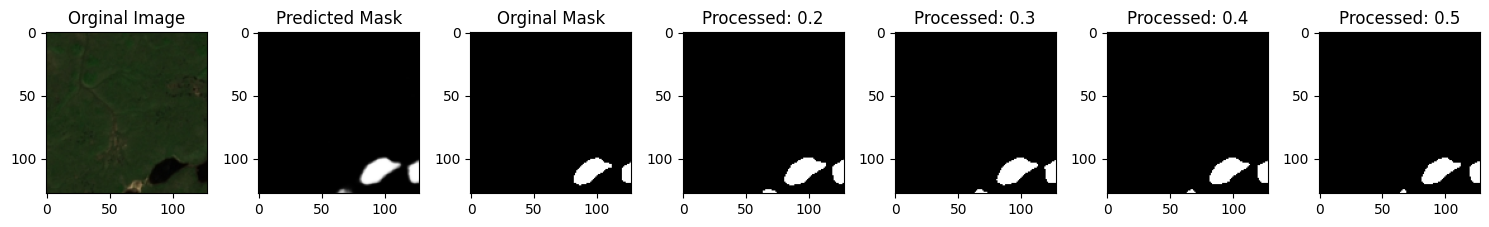

113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - accuracy: 0.6457 - loss: 0.2059
Epoch 63/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/stepstep - accuracy: 0.6426 - loss: 0.212


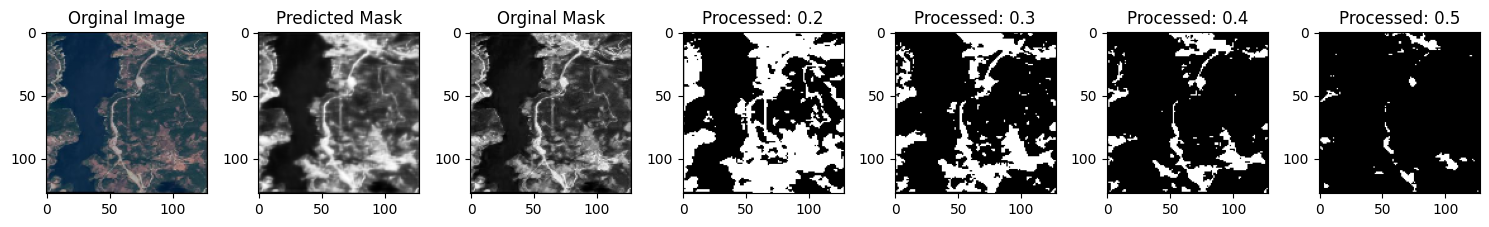

113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - accuracy: 0.6426 - loss: 0.2121
Epoch 64/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.6287 - loss: 0.22


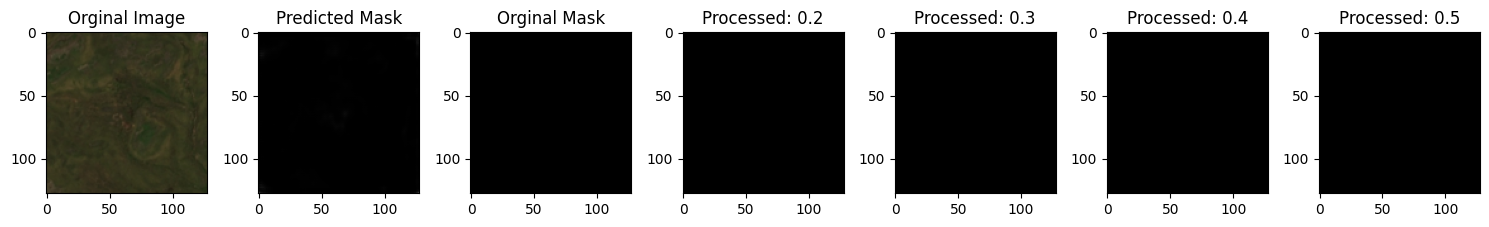

113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - accuracy: 0.6290 - loss: 0.2214
Epoch 65/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.6405 - loss: 0.214


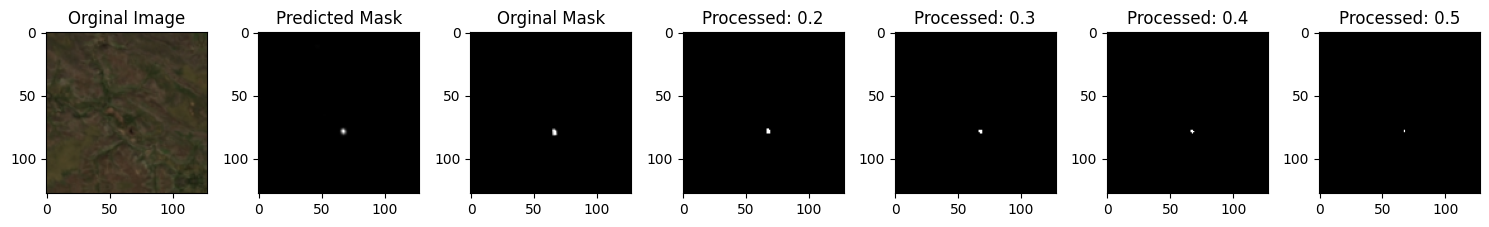

113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - accuracy: 0.6405 - loss: 0.2146
Epoch 66/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.6404 - loss: 0.21


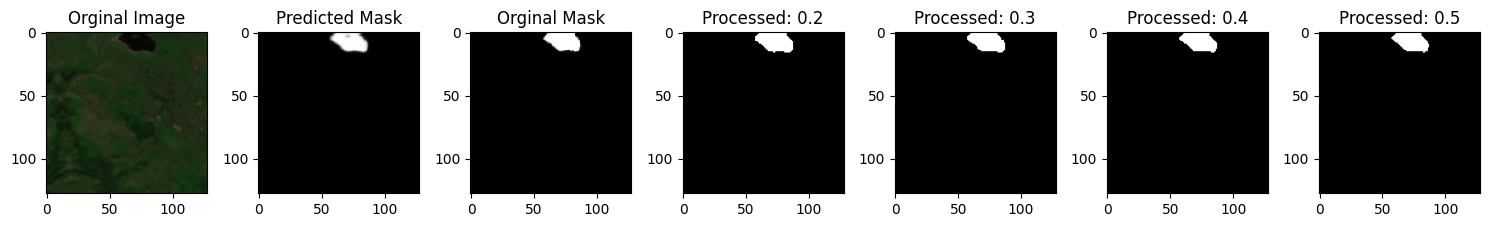

113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 82ms/step - accuracy: 0.6404 - loss: 0.2150
Epoch 67/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.6428 - loss: 0.21


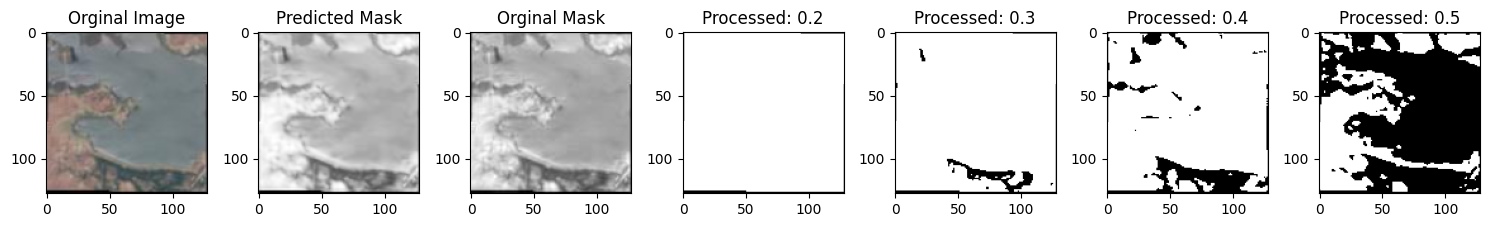

113/113 ━━━━━━━━━━━━━━━━━━━━ 10s 84ms/step - accuracy: 0.6428 - loss: 0.2106
Epoch 68/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.6438 - loss: 0.209


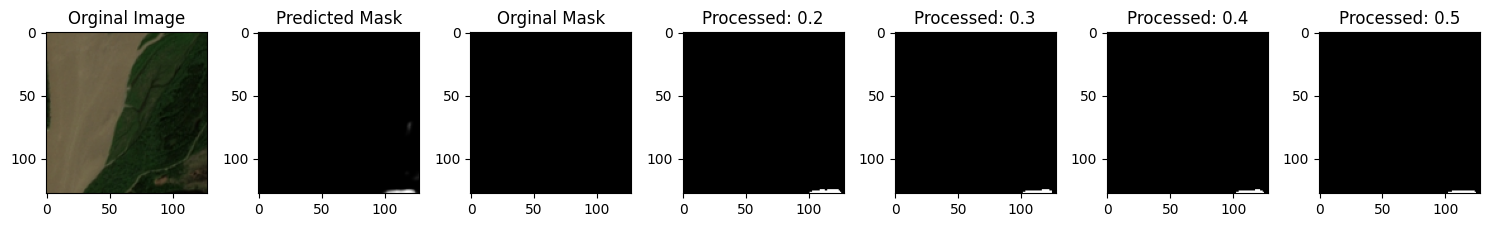

113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 82ms/step - accuracy: 0.6438 - loss: 0.2093
Epoch 69/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.6563 - loss: 0.20


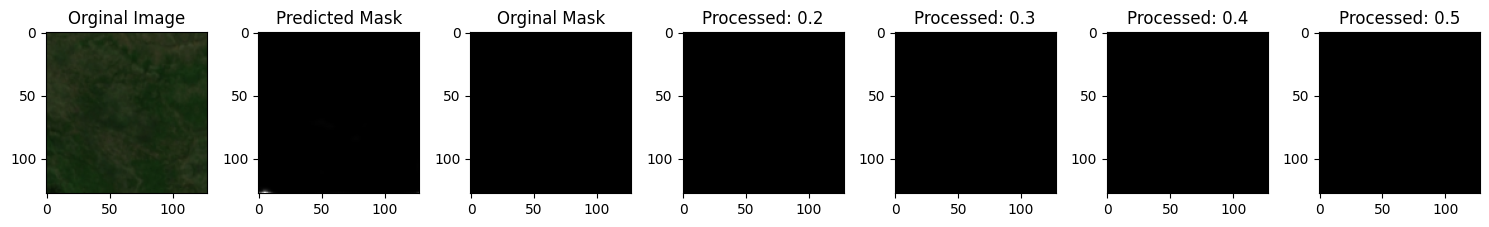

113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 82ms/step - accuracy: 0.6562 - loss: 0.2044
Epoch 70/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.6433 - loss: 0.20


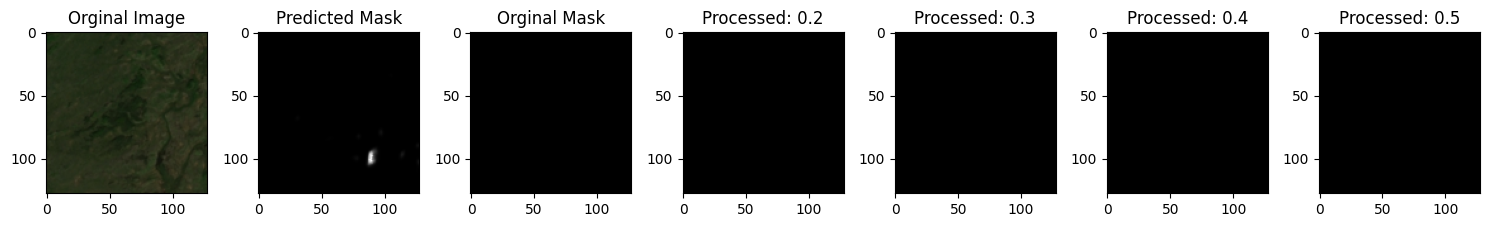

113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - accuracy: 0.6434 - loss: 0.2089
Epoch 71/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.6478 - loss: 0.206


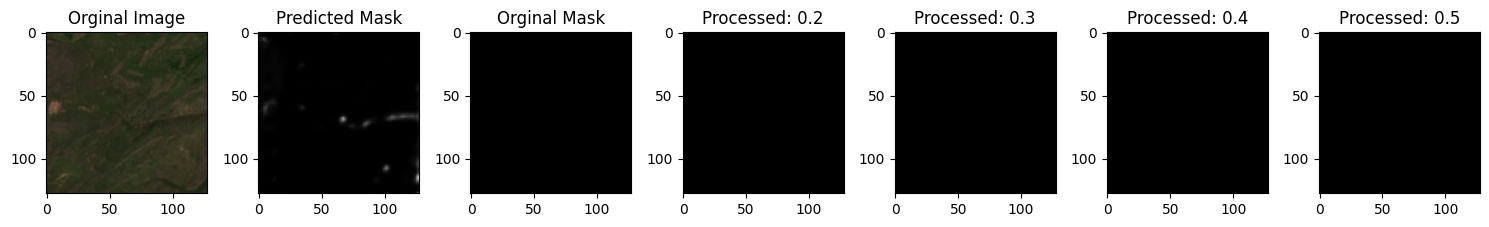

113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - accuracy: 0.6478 - loss: 0.2062
Epoch 72/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.6499 - loss: 0.20


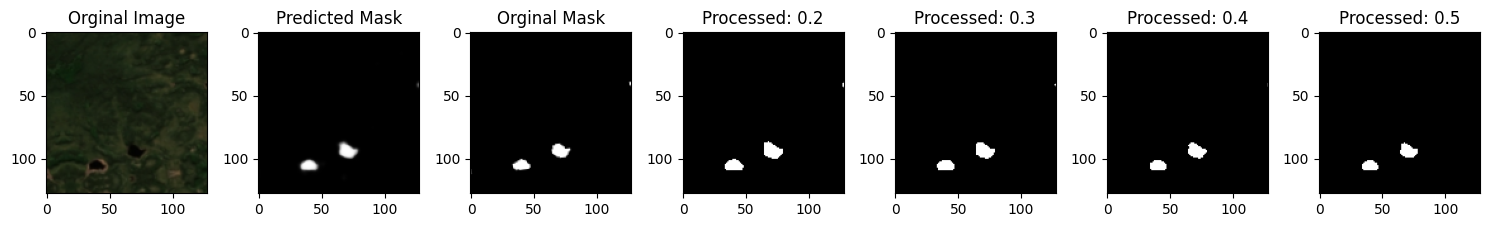

113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 82ms/step - accuracy: 0.6498 - loss: 0.2061
Epoch 73/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/stepstep - accuracy: 0.6541 - loss: 0.202


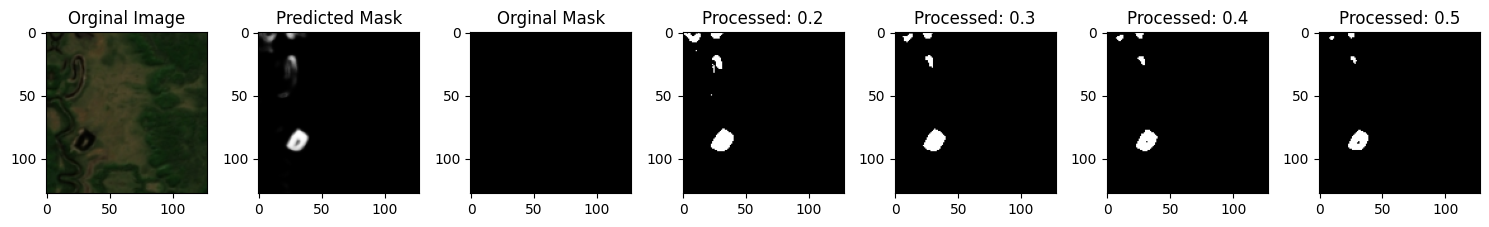

113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 82ms/step - accuracy: 0.6540 - loss: 0.2029
Epoch 74/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.6448 - loss: 0.20


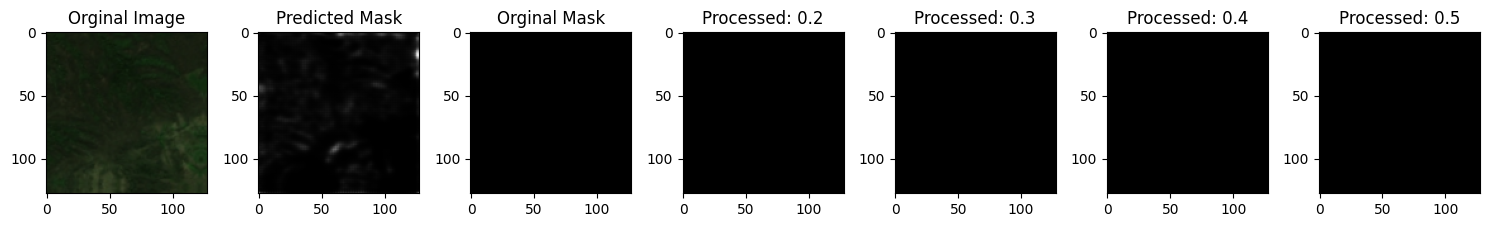

113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 84ms/step - accuracy: 0.6448 - loss: 0.2088
Epoch 75/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accuracy: 0.6468 - loss: 0.207


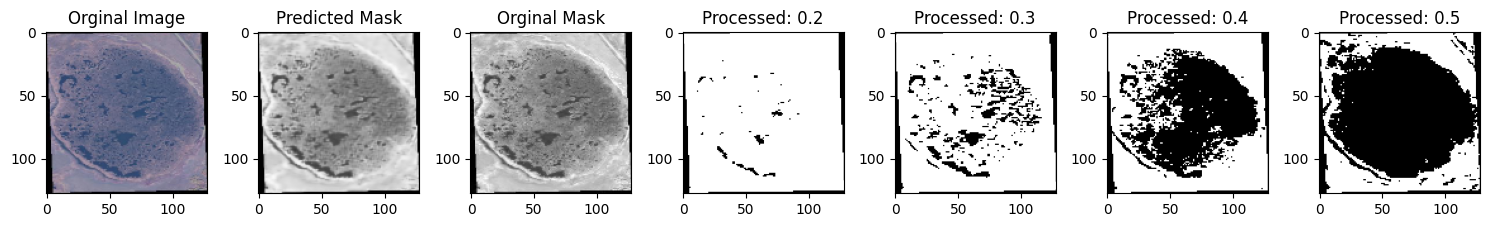

113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - accuracy: 0.6468 - loss: 0.2075


In [9]:
epochs = 75
batch_size = 64

if len(images_train) > 0 and len(masks_train) > 0:
    history = model.fit(
        images_train, 
        masks_train,  
        epochs=epochs,
        callbacks=[ShowProgress()],
        batch_size=batch_size,
        shuffle=True             # Make sure to shuffle
    )
else:
    print("No data to train on. Please check the data loading and preprocessing steps.")

In [10]:
from datetime import datetime

# Get the current date and time
current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# Save the model with the current date and time in the filename
if len(images_train) > 0: # Only save if training occurred
    model.save(f"../models/{current_time}_augmented_newdata.keras")
    print(f"Model saved as ../models/{current_time}_augmented_newdata.keras")
else:
    print("Model not saved as no training was performed.")

Model saved as ../models/2025-08-04_23-43-56_augmented_newdata.keras
